<a href="https://colab.research.google.com/github/stvngo/Algoverse-AI-Model-Probing/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PTS Dataset Cleaning and Preprocessing

-Steven

Link to our GitHub repository: https://github.com/stvngo/Algoverse-AI-Model-Probing

My main notebook (with probe): https://colab.research.google.com/drive/1lPYyJzPMA3MBKDzJQ-X3hVCp_kEFky1s#scrollTo=363e9e8d&uniqifier=2

In [ ]:
# install necessary libraries
!pip install datasets --upgrade
!pip install transformers --upgrade
!pip install einops --upgrade
# !pip install flash-attn --upgrade # original PTS settings use flash attention 2, for some reason doesn't work

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 141.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 53.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.5
    Uninstalling huggingface-hub-0.33.5:
      Successfully uninstalled huggingface-hub-0.33.5
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3


In [ ]:
import logging

# Configure logging for visibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # for saving

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Global Random Seeds

For reproducibility of experiments

In [ ]:
import random
import numpy as np
import torch

# Set global random seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)


# If using CUDA, also set the seed for CUDA operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # For multi-GPU

print(f"Global random seeds set to {seed_value} for random, numpy, and torch.")

Global random seeds set to 42 for random, numpy, and torch.


# Load Model

In [ ]:
# import necessary packages
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import time # Import time for timing

# manual seed for reproducibility
torch.manual_seed(42)

# torch.set_default_device("cuda")

# check device availability (save resources)
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch, 'backends') and hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = "mps"
else:

    device = "cpu"

print(f"Using device: {device}")

# model name
model_name = "Qwen/Qwen3-0.6B"

# # Check if flash attention is available
# use_flash_attention = False
# try:
#     import flash_attn
#     print("Flash Attention 2 is available and will be used")
#     use_flash_attention = True
# except ImportError:
#     print("Flash Attention 2 is not available, using standard attention")

# Add flash attention to config if available
model_kwargs = {
    "trust_remote_code": True,
    "device_map": device,
    "output_hidden_states":True
}

# if use_flash_attention:
#     # Flash Attention requires either float16 or bfloat16
#     if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8:
#         # Use bfloat16 for Ampere or newer GPUs (compute capability 8.0+)
#         model_kwargs["torch_dtype"] = torch.bfloat16
#         print("Using bfloat16 precision with Flash Attention")
#     else:
#         # Use float16 for older GPUs
#         model_kwargs["torch_dtype"] = torch.float16
#         print("Using float16 precision with Flash Attention")

#     model_kwargs["attn_implementation"] = "flash_attention_2"

# load model and tokenizer
# Ensure model and tokenizer are on the correct device AFTER loading
model = AutoModelForCausalLM.from_pretrained(model_name, **model_kwargs)


# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side='left')
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # set padding side if batching

# Set padding token if not set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Model and tokenizer loaded.")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model and tokenizer loaded.


In [ ]:
# print(model.config) # check if we're using flash attention 2

# Load Dataset

- Load dataset through huggingface path
- Imported sklearn train and test split function
- First, we split by query, then create many negative examples while extracting token positions and labels.
- Then, drop duplicate rows.
- Lastly, balance the dataset with twice the original shape

In [ ]:
from datasets import load_dataset, Dataset
from typing import List, Dict, Tuple, Optional
from sklearn.model_selection import train_test_split
import pandas as pd

def split_pts_by_query(dataset_path: str, test_size: float = 0.2, subset_size: Optional[int] = None) -> Tuple[Dataset, Dataset]:
    """
    Load PTS dataset, remove duplicates, and split by query ID to avoid data leakage.

    :param dataset_path: Path/name of your PTS dataset on HuggingFace
    :param test_size: Fraction for test split
    :param subset_size: If provided, creates a subset of the dataset for debugging.
    :return: train_dataset, test_dataset split by query
    """
    # Load the PTS dataset with explicit configuration
    print(f"Loading dataset: {dataset_path}")

    try:
        # Try loading without any wildcards or special patterns
        dataset = load_dataset(dataset_path, split='train')
        print(f"Loaded {len(dataset)} examples")

    except Exception as e:
        print(f"Error with split='train', trying default loading: {e}")
        try:
            # Try loading all splits then select one
            dataset_dict = load_dataset(dataset_path)
            print(f"Available splits: {list(dataset_dict.keys())}")

            # Get the main split
            if 'train' in dataset_dict:
                dataset = dataset_dict['train']
            else:
                split_name = list(dataset_dict.keys())[0]
                dataset = dataset_dict[split_name]
                print(f"Using split: {split_name}")

        except Exception as e2:
            print(f"Final error: {e2}")
            print("Try loading the dataset manually first to debug")
            raise e2

    # Create a subset if requested
    if subset_size:
        dataset = dataset.select(range(min(subset_size, len(dataset))))
        print(f"Using a subset of {len(dataset)} examples for debugging.")

    # Remove duplicates
    df = dataset.to_pandas()

    # Drop the timestamp column if it exists
    if 'timestamp' in df.columns:
        df = df.drop(columns=['timestamp'])
        print("Dropped the 'timestamp' column.")

    num_rows_before = len(df)
    df_deduplicated = df.drop_duplicates()
    num_rows_after = len(df_deduplicated)
    num_duplicates_removed = num_rows_before - num_rows_after

    print(f"Removed {num_duplicates_removed} duplicate rows.")
    print(f"Number of rows left: {num_rows_after}")

    # Count number of examples where first token is pivotal
    count = 0
    for _, row in df_deduplicated.iterrows():
        if row["query"] == row['pivot_context']:
            count += 1

    total_examples = len(df_deduplicated)
    percentage = (count / total_examples) * 100

    print(f"Sanity Check Results:")
    print(f"Number of examples where the first token after the query is pivotal: {count}")
    print(f"Total number of examples: {total_examples}")
    print(f"Percentage: {percentage:.2f}%")

    dataset = Dataset.from_pandas(df_deduplicated)


    # Get unique query IDs
    unique_query_ids = list(set(dataset['dataset_item_id']))
    print(f"Total unique queries: {len(unique_query_ids)}")

    # Split query IDs (not individual examples)
    train_query_ids, test_query_ids = train_test_split( # train: 1,3,4,... | test: 2,5,...
        unique_query_ids,
        test_size=test_size,
        random_state=42 # for reproducibility
    )

    # Filter dataset by query splits
    train_dataset = dataset.filter(lambda x: x['dataset_item_id'] in train_query_ids)
    test_dataset = dataset.filter(lambda x: x['dataset_item_id'] in test_query_ids)

    print(f"Train queries: {len(train_query_ids)}, Train examples: {len(train_dataset)}")
    print(f"Test queries: {len(test_query_ids)}, Test examples: {len(test_dataset)}")

    return train_dataset, test_dataset

In [ ]:
train_raw, test_raw = split_pts_by_query("codelion/Qwen3-0.6B-pts", test_size=0.2)
print(train_raw)
print(test_raw)

Loading dataset: codelion/Qwen3-0.6B-pts


README.md: 0.00B [00:00, ?B/s]

gsm8k_pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Loaded 1376 examples
Dropped the 'timestamp' column.
Removed 131 duplicate rows.
Number of rows left: 1245
Sanity Check Results:
Number of examples where the first token after the query is pivotal: 76
Total number of examples: 1245
Percentage: 6.10%
Total unique queries: 104


Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Train queries: 83, Train examples: 980
Test queries: 21, Test examples: 265
Dataset({
    features: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', '__index_level_0__'],
    num_rows: 980
})
Dataset({
    features: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', '__index_level_0__'],
    num_rows: 265
})


# Run either all in "FIRST METHOD" or all in "SECOND METHOD" section. Don't run both sections.

# FIRST METHOD: Without batching

Notes:
- Slower but I'm sure all the labels will be correct.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset as HFDataset # Use alias to avoid conflict
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm # Import tqdm for progress bars
import pandas as pd
from collections import defaultdict

def generate_full_responses_and_prepare_data(
    raw_dataset: HFDataset,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    device: torch.device,
    generation_params: Dict,
    max_new_tokens: int = 8192, # Max tokens to generate for full response, 8192 was the original
) -> List[Dict]:
    """
    Generate full model responses and prepare a BALANCED dataset for linear probe training.
    For each row in the raw_dataset, it samples one positive and one negative example.
    The negative example is sampled ONLY from the generated answer part of the text.

    :param raw_dataset: HuggingFace dataset containing raw PTS data.
    :param model: The language model for generation.
    :param tokenizer: The tokenizer for the model.
    :param device: The device to run the model on.
    :param generation_params: Dictionary of generation parameters.
    :param max_new_tokens: Maximum new tokens for the response.
    :return: A balanced list of dictionaries (one positive, one negative per raw example).
    """
    all_examples = []
    model.to(device)
    model.eval()

    print(f"Generating balanced data from {len(raw_dataset)} raw examples...")

    gen_kwargs = {
        "do_sample": True,
        "temperature": generation_params.get("temperature", 0.6),
        "top_p": generation_params.get("top_p", 0.95),
        "top_k": generation_params.get("top_k", 20),
        "min_p": generation_params.get("min_p", 0.0),
        "max_new_tokens": max_new_tokens,
        "eos_token_id": tokenizer.eos_token_id,
        "use_cache": True,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Tokenize all texts at once for efficiency
    tokenized_pivot_contexts = tokenizer([ex['pivot_context'] for ex in raw_dataset], add_special_tokens=False)
    tokenized_queries = tokenizer([ex['query'] for ex in raw_dataset], add_special_tokens=False)

    for i, example in enumerate(tqdm(raw_dataset, desc="Generating and Processing Examples")):
        pivot_context = example['pivot_context']
        original_pivot_token = example['pivot_token']
        query = example['query']
        dataset_item_id = example.get('dataset_item_id', None)

        # Prepare the prompt for the model
        prompt_for_generation = pivot_context + original_pivot_token

        # Tokenize the prompt
        inputs = tokenizer(prompt_for_generation, return_tensors='pt', add_special_tokens=False).to(device)

        with torch.no_grad():
            generation_outputs = model.generate(
                **inputs,
                **gen_kwargs
            )

        # Process the generated response
        full_generated_ids = generation_outputs.sequences[0]
        full_generated_text = tokenizer.decode(full_generated_ids, skip_special_tokens=True)
        full_seq_len = len(full_generated_ids)

        # Get the length of the query in tokens from the pre-tokenized inputs
        query_len_in_tokens = len(tokenized_queries['input_ids'][i])

        # The positive position is the last token of the `pivot_context`.
        positive_position_in_full = len(tokenized_pivot_contexts['input_ids'][i]) - 1


        # --- Add the positive example ---
        all_examples.append({
            'text': full_generated_text,
            'token_position': positive_position_in_full,
            'label': 1,
            'original_dataset_item_id': dataset_item_id,
            'source_raw_index': i
        })

        # --- Sample one negative example from the ANSWER part only ---
        # The "answer" part starts from and includes the last token of the original query.
        possible_negative_positions = list(range(query_len_in_tokens - 1, full_seq_len))

        # Ensure the positive position is not accidentally re-sampled as a negative.
        if positive_position_in_full in possible_negative_positions:
            possible_negative_positions.remove(positive_position_in_full)

        if possible_negative_positions:
            negative_position = random.choice(possible_negative_positions)
            all_examples.append({
                'text': full_generated_text,
                'token_position': negative_position,
                'label': 0,
                'original_dataset_item_id': dataset_item_id,
                'source_raw_index': i
            })

    print(f"Collected {len(all_examples)} total examples (pre-balanced).")
    # Shuffle the final list to mix positive and negative examples
    random.shuffle(all_examples)
    return all_examples

In [ ]:
# Re-execute the split function to get the raw datasets
# Using subset_size=20 for debugging
train_raw, test_raw = split_pts_by_query("codelion/Qwen3-0.6B-pts", test_size=0.2)

# Define generation parameters
generation_params = {
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
}

# Now call the data preparation function with the raw datasets and generation parameters
train_examples_raw_list = generate_full_responses_and_prepare_data(train_raw, model, tokenizer, device, generation_params, max_new_tokens=512)
test_examples_raw_list = generate_full_responses_and_prepare_data(test_raw, model, tokenizer, device, generation_params, max_new_tokens=512)

print(f"\nPrepared {len(train_examples_raw_list)} raw examples for training.")
print(f"Prepared {len(test_examples_raw_list)} raw examples for testing.")

Loading dataset: codelion/Qwen3-0.6B-pts


README.md: 0.00B [00:00, ?B/s]

gsm8k_pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Loaded 1376 examples
Dropped the 'timestamp' column.
Removed 131 duplicate rows.
Number of rows left: 1245
Sanity Check Results:
Number of examples where the first token after the query is pivotal: 76
Total number of examples: 1245
Percentage: 6.10%
Total unique queries: 104


Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Train queries: 83, Train examples: 1028
Test queries: 21, Test examples: 217
Generating balanced data from 1028 raw examples...


Generating and Processing Examples:   0%|          | 0/1028 [00:00<?, ?it/s]

Collected 2056 total examples (pre-balanced).
Generating balanced data from 217 raw examples...


Generating and Processing Examples:   0%|          | 0/217 [00:00<?, ?it/s]

Collected 434 total examples (pre-balanced).

Prepared 2056 raw examples for training.
Prepared 434 raw examples for testing.


In [ ]:
# View some examples

train_dataset_balanced = train_examples_raw_list
test_dataset_balanced = test_examples_raw_list

print("Example from balanced train dataset:")
for i in range(len(train_dataset_balanced)):
  print(train_dataset_balanced[i])

print("\nExample from balanced test dataset:")
for i in range(len(test_dataset_balanced)):
  print(test_dataset_balanced[i])

Example from balanced train dataset:
{'text': "Ben has 8 apples more than Phillip does. Tom has three eighths as many apples at Ben has. If Phillip has 40 apples, how many apples does Tom have? Let's solve this problem step by step. \n\nFirst, we need to find out how many apples Ben has. Since Ben has 8 apples more than Phillip, and Phillip has 40 apples, we can calculate Ben's apples as follows:\n\nBen's apples = Phillip's apples + 8\nBen's apples = 40 + 8\nBen's apples = 48\n\nNow, we need to find out how many apples Tom has. We are told that Tom has three eighths as many apples as Ben does. So, we can calculate the number of apples Tom has by multiplying Ben's apples by 3/8:\n\nTom's apples = Ben's apples * 3/8\nTom's apples = 48 * (3/8)\n\nLet's compute this:\n\n48 * 3 = 144\n144 / 8 = 18\n\nTherefore, Tom has 18 apples. \n\nLet me double-check the calculations to make sure there are no errors. \n\n1. Ben's apples: 40 + 8 = 48 ✔️\n2. Tom's apples: 48 * 3/8 = 18 ✔️\n\nEverything see

In [ ]:
print(tokenizer("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply", return_tensors='pt', add_special_tokens=False)["input_ids"].shape[1] - 1)
print(tokenizer("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? \n\n", return_tensors='pt', add_special_tokens=False)["input_ids"].shape[1] - 1, ", notice there are two newline characters")

38
31 , notice there are two newline characters


In [ ]:
import os
import shutil
from datasets import Dataset as HFDataset # Use alias

# Convert the lists to HuggingFace Datasets
train_dataset_balanced_hf = HFDataset.from_list(train_dataset_balanced)
test_dataset_balanced_hf = HFDataset.from_list(test_dataset_balanced)

# Define directories for saving the balanced datasets
BALANCED_DATA_SAVE_DIR_LOCAL = "./balanced_datasets"
os.makedirs(BALANCED_DATA_SAVE_DIR_LOCAL, exist_ok=True)

# Define the base directory in Google Drive to save the balanced datasets
# This should ideally be within your project folder in Drive
BALANCED_DATA_SAVE_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/balanced_datasets_backup' # ADJUST THIS PATH AS NEEDED
# Ensure the base directory exists in Drive (this will be checked during saving)
os.makedirs(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, exist_ok=True)


# Define specific paths for the train and test datasets
TRAIN_DATA_SAVE_PATH_LOCAL = os.path.join(BALANCED_DATA_SAVE_DIR_LOCAL, "train_dataset_balanced_WITHOUT_BATCHING")
TEST_DATA_SAVE_PATH_LOCAL = os.path.join(BALANCED_DATA_SAVE_DIR_LOCAL, "test_dataset_balanced_WITHOUT_BATCHING")

TRAIN_DATA_SAVE_PATH_DRIVE = os.path.join(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, "train_dataset_balanced_WITHOUT_BATCHING")
TEST_DATA_SAVE_PATH_DRIVE = os.path.join(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, "test_dataset_balanced_WITHOUT_BATCHING")

logging.info("Saving balanced train dataset locally...")
try:
    train_dataset_balanced_hf.save_to_disk(TRAIN_DATA_SAVE_PATH_LOCAL)
    logging.info(f"Balanced train dataset saved locally to {TRAIN_DATA_SAVE_PATH_LOCAL}")

    # Copy to Google Drive
    logging.info(f"Copying balanced train dataset to Google Drive at {TRAIN_DATA_SAVE_PATH_DRIVE}...")
    # Use shutil.copytree to copy the directory
    # Use dirs_exist_ok=True for Python 3.8+ to overwrite if it exists
    shutil.copytree(TRAIN_DATA_SAVE_PATH_LOCAL, TRAIN_DATA_SAVE_PATH_DRIVE, dirs_exist_ok=True)
    logging.info("Finished copying balanced train dataset to Google Drive.")

except Exception as e:
    logging.error(f"Error saving or copying balanced train dataset: {e}")
    logging.warning("Ensure Google Drive is mounted and the path is correct.")


logging.info("Saving balanced test dataset locally...")
try:
    test_dataset_balanced_hf.save_to_disk(TEST_DATA_SAVE_PATH_LOCAL)
    logging.info(f"Balanced test dataset saved locally to {TEST_DATA_SAVE_PATH_LOCAL}")

    # Copy to Google Drive
    logging.info(f"Copying balanced test dataset to Google Drive at {TEST_DATA_SAVE_PATH_DRIVE}...")
    # Use shutil.copytree to copy the directory
    shutil.copytree(TEST_DATA_SAVE_PATH_LOCAL, TEST_DATA_SAVE_PATH_DRIVE, dirs_exist_ok=True)
    logging.info("Finished copying balanced test dataset to Google Drive.")

except Exception as e:
    logging.error(f"Error saving or copying balanced test dataset: {e}")
    logging.warning("Ensure Google Drive is mounted and the path is correct.")

In [ ]:
import os
print(os.path.exists("/content/drive/My Drive"))

False


# SECOND METHOD: Use DataLoaders and Batching

Notes:

- Faster but positions may be flawed (it's pretty complicated to understand)

- When batching, used padding and truncation
- When loading the model, set tokenizer.pad_token = tokenizer.eso_token, and AutoTokenizer.from_pretrained(..., padding_size='left')
- If available, use flash attention 2 (dtype=torch.bfloat16)
- Set max_new_tokens high enough such that truncation has little effect
- **Runs the risk of overcomplicating the negative positions because of the padding and truncation**
  - Needs to perform some calculations for the "offset", such that padding tokens are being fully account3ed for when calculating the answer_start_position for negative sampling.


Positives are safely created for both methods I've shown, it's really a **tradeoff between time complexity vs. feasibility of labelling the right positions**.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset as HFDataset # Use alias to avoid conflict
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm # Import tqdm for progress bars
import pandas as pd
from collections import defaultdict

def generate_full_responses_and_prepare_data(
    raw_dataset: HFDataset,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    device: torch.device,
    generation_params: Dict,
    batch_size: int = 5, # Add batch_size parameter, original was 5
    max_new_tokens: int = 8192, # Max tokens to generate for full response, original was 8192, use 512 for efficiency?
) -> List[Dict]:
    """
    Generate full model responses and prepare a BALANCED dataset for linear probe training.
    For each row in the raw_dataset, it samples one positive and one negative example.
    The negative example is sampled ONLY from the generated answer part of the text.

    :param raw_dataset: HuggingFace dataset containing raw PTS data.
    :param model: The language model for generation.
    :param tokenizer: The tokenizer for the model.
    :param device: The device to run the model on.
    :param generation_params: Dictionary of generation parameters.
    :param batch_size: The batch size for generation.
    :param max_new_tokens: Maximum new tokens for the response.
    :return: A balanced list of dictionaries (one positive, one negative per raw example).
    """
    all_examples = []
    model.to(device)
    model.eval()

    print(f"Generating balanced data from {len(raw_dataset)} raw examples...")

    gen_kwargs = {
        "do_sample": True,
        "temperature": generation_params.get("temperature", 0.6),
        "top_p": generation_params.get("top_p", 0.95),
        "top_k": generation_params.get("top_k", 20),
        "min_p": generation_params.get("min_p", 0.0),
        "max_new_tokens": max_new_tokens,
        "pad_token_id": tokenizer.pad_token_id,
        "eos_token_id": tokenizer.eos_token_id,
        "use_cache": True,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Create a DataLoader to process the data in batches
    dataloader = DataLoader(raw_dataset, batch_size=batch_size)

    for batch in tqdm(dataloader, desc="Generating and Processing Examples"):
        # The dataloader returns a dictionary of lists. We need to extract the lists.
        pivot_contexts = batch['pivot_context']
        original_pivot_tokens = batch['pivot_token']
        queries = batch['query']
        dataset_item_ids = batch.get('dataset_item_id', [None] * len(pivot_contexts))

        # Prepare the prompts for the batch
        prompts_for_generation = [pc + opt for pc, opt in zip(pivot_contexts, original_pivot_tokens)]

        # Tokenize the batch of prompts
        inputs = tokenizer(prompts_for_generation, return_tensors='pt', padding=True, truncation=True, add_special_tokens=False).to(device)

        with torch.no_grad():
            generation_outputs = model.generate(
                **inputs,
                **gen_kwargs
            )

        # Process each example in the batch
        for i in range(len(prompts_for_generation)):
            full_generated_ids = generation_outputs.sequences[i]
            full_generated_text = tokenizer.decode(full_generated_ids, skip_special_tokens=True)

            # Correctly calculate the number of padding tokens on the left
            padding_len = (inputs.input_ids[i] == tokenizer.pad_token_id).sum().item()

            # Get the length of the query and context in tokens
            query_len_in_tokens = tokenizer(queries[i], return_tensors='pt', add_special_tokens=False)['input_ids'].shape[1]
            context_len_in_tokens = tokenizer(pivot_contexts[i], return_tensors='pt', add_special_tokens=False)['input_ids'].shape[1]

            # The positive position must be shifted by the padding length
            positive_position_in_full = padding_len + context_len_in_tokens - 1


            # --- Add the positive example ---
            all_examples.append({
                'text': full_generated_text,
                'token_position': positive_position_in_full,
                'label': 1,
                'original_dataset_item_id': dataset_item_ids[i],
                'source_raw_index': i # This index is now relative to the batch
            })

            # --- Sample one negative example from the ANSWER part only ---
            # The "answer" part starts after the query. This also must be shifted by padding.
            full_seq_len = len(full_generated_ids)
            answer_start_position = padding_len + query_len_in_tokens -1
            possible_negative_positions = list(range(answer_start_position, full_seq_len))

            # Ensure the positive position is not accidentally re-sampled as a negative.
            if positive_position_in_full in possible_negative_positions:
                possible_negative_positions.remove(positive_position_in_full)

            if possible_negative_positions:
                negative_position = random.choice(possible_negative_positions)
                all_examples.append({
                    'text': full_generated_text,
                    'token_position': negative_position,
                    'label': 0,
                    'original_dataset_item_id': dataset_item_ids[i],
                    'source_raw_index': i # This index is now relative to the batch
                })

    print(f"Collected {len(all_examples)} total examples (pre-balanced).")
    # Shuffle the final list to mix positive and negative examples
    random.shuffle(all_examples)
    return all_examples

In [ ]:
# Re-execute the split function to get the raw datasets
# Using subset_size=20 for debugging
train_raw, test_raw = split_pts_by_query("codelion/Qwen3-0.6B-pts", test_size=0.2)

# Define generation parameters
generation_params = {
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
}

# Now call the data preparation function with the raw datasets and generation parameters
# We can also specify a batch size for the generation process
train_examples_raw_list = generate_full_responses_and_prepare_data(train_raw, model, tokenizer, device, generation_params, batch_size=5, max_new_tokens=512)
test_examples_raw_list = generate_full_responses_and_prepare_data(test_raw, model, tokenizer, device, generation_params, batch_size=5, max_new_tokens=512)

print(f"\nPrepared {len(train_examples_raw_list)} raw examples for training.")
print(f"Prepared {len(test_examples_raw_list)} raw examples for testing.")

In [ ]:
# View some examples

train_dataset_balanced = train_examples_raw_list
test_dataset_balanced = test_examples_raw_list

print("Example from balanced train dataset:")
for i in range(len(train_dataset_balanced)):
  print(train_dataset_balanced[i])

print("\nExample from balanced test dataset:")
for i in range(len(test_dataset_balanced)):
  print(test_dataset_balanced[i])

In [ ]:
print(tokenizer("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply", return_tensors='pt', add_special_tokens=False)["input_ids"].shape[1] - 1)
print(tokenizer("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? \n\n", return_tensors='pt', add_special_tokens=False)["input_ids"].shape[1] - 1, ", notice there are two newline characters")

In [ ]:
import os
import shutil
from datasets import Dataset as HFDataset # Use alias

# Convert the lists to HuggingFace Datasets
train_dataset_balanced_hf = HFDataset.from_list(train_dataset_balanced)
test_dataset_balanced_hf = HFDataset.from_list(test_dataset_balanced)

# Define directories for saving the balanced datasets
BALANCED_DATA_SAVE_DIR_LOCAL = "./balanced_datasets"
os.makedirs(BALANCED_DATA_SAVE_DIR_LOCAL, exist_ok=True)

# Define the base directory in Google Drive to save the balanced datasets
# This should ideally be within your project folder in Drive
BALANCED_DATA_SAVE_DIR_DRIVE_BASE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/balanced_datasets_backup' # ADJUST THIS PATH AS NEEDED
# Ensure the base directory exists in Drive (this will be checked during saving)
os.makedirs(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, exist_ok=True)


# Define specific paths for the train and test datasets
TRAIN_DATA_SAVE_PATH_LOCAL = os.path.join(BALANCED_DATA_SAVE_DIR_LOCAL, "train_dataset_balanced_WITH_BATCHING")
TEST_DATA_SAVE_PATH_LOCAL = os.path.join(BALANCED_DATA_SAVE_DIR_LOCAL, "test_dataset_balanced_WITH_BATCHING")

TRAIN_DATA_SAVE_PATH_DRIVE = os.path.join(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, "train_dataset_balanced_WITH_BATCHING")
TEST_DATA_SAVE_PATH_DRIVE = os.path.join(BALANCED_DATA_SAVE_DIR_DRIVE_BASE, "test_dataset_balanced_WITH_BATCHING")

logging.info("Saving balanced train dataset locally...")
try:
    train_dataset_balanced_hf.save_to_disk(TRAIN_DATA_SAVE_PATH_LOCAL)
    logging.info(f"Balanced train dataset saved locally to {TRAIN_DATA_SAVE_PATH_LOCAL}")

    # Copy to Google Drive
    logging.info(f"Copying balanced train dataset to Google Drive at {TRAIN_DATA_SAVE_PATH_DRIVE}...")
    # Use shutil.copytree to copy the directory
    # Use dirs_exist_ok=True for Python 3.8+ to overwrite if it exists
    shutil.copytree(TRAIN_DATA_SAVE_PATH_LOCAL, TRAIN_DATA_SAVE_PATH_DRIVE, dirs_exist_ok=True)
    logging.info("Finished copying balanced train dataset to Google Drive.")

except Exception as e:
    logging.error(f"Error saving or copying balanced train dataset: {e}")
    logging.warning("Ensure Google Drive is mounted and the path is correct.")


logging.info("Saving balanced test dataset locally...")
try:
    test_dataset_balanced_hf.save_to_disk(TEST_DATA_SAVE_PATH_LOCAL)
    logging.info(f"Balanced test dataset saved locally to {TEST_DATA_SAVE_PATH_LOCAL}")

    # Copy to Google Drive
    logging.info(f"Copying balanced test dataset to Google Drive at {TEST_DATA_SAVE_PATH_DRIVE}...")
    # Use shutil.copytree to copy the directory
    shutil.copytree(TEST_DATA_SAVE_PATH_LOCAL, TEST_DATA_SAVE_PATH_DRIVE, dirs_exist_ok=True)
    logging.info("Finished copying balanced test dataset to Google Drive.")

except Exception as e:
    logging.error(f"Error saving or copying balanced test dataset: {e}")
    logging.warning("Ensure Google Drive is mounted and the path is correct.")

## Load Balanced Datasets

Use this cell to load previously saved balanced datasets instead of regenerating them.

In [ ]:
import os
from datasets import load_from_disk

# Define directories where the balanced datasets are saved
# Prioritize loading from Drive if mounted and available
BALANCED_DATA_LOAD_DIR_DRIVE_BASE = '/content/drive/MyDrive/Zurabi_AI_Data' # ADJUST THIS PATH AS NEEDED
BALANCED_DATA_LOAD_DIR_LOCAL = "./balanced_datasets"

# Define specific paths for the train and test datasets
TRAIN_DATA_LOAD_PATH_DRIVE = os.path.join(BALANCED_DATA_LOAD_DIR_DRIVE_BASE, "train_dataset_balanced_WITHOUT_BATCHING") # CHANGE AS NEEDED
TEST_DATA_LOAD_PATH_DRIVE = os.path.join(BALANCED_DATA_LOAD_DIR_DRIVE_BASE, "test_dataset_balanced_WITHOUT_BATCHING") # CHANGE AS NEEDED

TRAIN_DATA_LOAD_PATH_LOCAL = os.path.join(BALANCED_DATA_LOAD_DIR_LOCAL, "train_dataset_balanced_WITHOUT_BATCHING") # CHANGE AS NEEDED
TEST_DATA_LOAD_PATH_LOCAL = os.path.join(BALANCED_DATA_LOAD_DIR_LOCAL, "test_dataset_balanced_WITHOUT_BATCHING") # CHANGE AS NEEDED


# Attempt to load train dataset, prioritizing Drive
train_dataset_balanced = None
if os.path.exists('/content/drive') and os.path.exists(TRAIN_DATA_LOAD_PATH_DRIVE):
    logging.info(f"Attempting to load balanced train dataset from Google Drive at {TRAIN_DATA_LOAD_PATH_DRIVE}...")
    try:
        train_dataset_balanced = load_from_disk(TRAIN_DATA_LOAD_PATH_DRIVE)
        logging.info("Successfully loaded balanced train dataset from Google Drive.")
    except Exception as e:
        logging.warning(f"Could not load from Google Drive: {e}. Checking local path.")

if train_dataset_balanced is None and os.path.exists(TRAIN_DATA_LOAD_PATH_LOCAL):
    logging.info(f"Attempting to load balanced train dataset from local path at {TRAIN_DATA_LOAD_PATH_LOCAL}...")
    try:
        train_dataset_balanced = load_from_disk(TRAIN_DATA_LOAD_PATH_LOCAL)
        logging.info("Successfully loaded balanced train dataset from local path.")
    except Exception as e:
        logging.error(f"Could not load from local path: {e}. Balanced train dataset not loaded.")


# Attempt to load test dataset, prioritizing Drive
test_dataset_balanced = None
if os.path.exists('/content/drive') and os.path.exists(TEST_DATA_LOAD_PATH_DRIVE):
    logging.info(f"Attempting to load balanced test dataset from Google Drive at {TEST_DATA_LOAD_PATH_DRIVE}...")
    try:
        test_dataset_balanced = load_from_disk(TEST_DATA_LOAD_PATH_DRIVE)
        logging.info("Successfully loaded balanced test dataset from Google Drive.")
    except Exception as e:
        logging.warning(f"Could not load from Google Drive: {e}. Checking local path.")

if test_dataset_balanced is None and os.path.exists(TEST_DATA_LOAD_PATH_LOCAL):
    logging.info(f"Attempting to load balanced test dataset from local path at {TEST_DATA_LOAD_PATH_LOCAL}...")
    try:
        test_dataset_balanced = load_from_disk(TEST_DATA_LOAD_PATH_LOCAL)
        logging.info("Successfully loaded balanced test dataset from local path.")
    except Exception as e:
        logging.error(f"Could not load from local path: {e}. Balanced test dataset not loaded.")


# You can add checks here to see if the datasets were loaded successfully
if train_dataset_balanced is not None:
    print(f"Loaded balanced train dataset with {len(train_dataset_balanced)} examples.")
else:
    print("Balanced train dataset was not loaded. You will need to generate it.")

if test_dataset_balanced is not None:
    print(f"Loaded balanced test dataset with {len(test_dataset_balanced)} examples.")
else:
    print("Balanced test dataset was not loaded. You will need to generate it.")

# Note: After loading, you would proceed to create DataLoaders from these datasets
# in the next cell (the training loop cell), but you would skip the data generation and balancing steps there.

Loaded balanced train dataset with 2056 examples.
Loaded balanced test dataset with 434 examples.


In [ ]:
print("Example from balanced train dataset:")
print(train_dataset_balanced[0])

print("\nExample from balanced test dataset:")
print(test_dataset_balanced[0])

Example from balanced train dataset:
{'text': "Ben has 8 apples more than Phillip does. Tom has three eighths as many apples at Ben has. If Phillip has 40 apples, how many apples does Tom have? Let's solve this problem step by step. \n\nFirst, we need to find out how many apples Ben has. Since Ben has 8 apples more than Phillip, and Phillip has 40 apples, we can calculate Ben's apples as follows:\n\nBen's apples = Phillip's apples + 8\nBen's apples = 40 + 8\nBen's apples = 48\n\nNow, we need to find out how many apples Tom has. We are told that Tom has three eighths as many apples as Ben does. So, we can calculate the number of apples Tom has by multiplying Ben's apples by 3/8:\n\nTom's apples = Ben's apples * 3/8\nTom's apples = 48 * (3/8)\n\nLet's compute this:\n\n48 * 3 = 144\n144 / 8 = 18\n\nTherefore, Tom has 18 apples. \n\nLet me double-check the calculations to make sure there are no errors. \n\n1. Ben's apples: 40 + 8 = 48 ✔️\n2. Tom's apples: 48 * 3/8 = 18 ✔️\n\nEverything see

Prevent Colab runtime disconnecting:

In [ ]:
# from pynput.mouse import Controller, Button
# import time

# mouse = Controller()

# while True:
#   mouse.click(Button.left, 1)
#   print('clicked')

#   time.sleep(300)

In [ ]:
from collections import defaultdict

# Let's reuse the train_raw dataset that is already loaded.
# First, we need to group the examples by query ID.
train_query_groups = defaultdict(list)
for example in train_raw:
    train_query_groups[example['dataset_item_id']].append(example)

# Now, let's pick one query group to inspect. We can look at a few.
# We'll find one with multiple examples to make the check meaningful.
query_id_to_inspect = None
for q_id, examples in train_query_groups.items():
    if len(examples) > 5: # Pick a query with a good number of associated examples
        query_id_to_inspect = q_id
        break

if query_id_to_inspect:
    print(f"Inspecting query ID: {query_id_to_inspect}")
    examples_to_check = train_query_groups[query_id_to_inspect]

    # Find the longest pivot_context in this group
    longest_example = max(examples_to_check, key=lambda ex: len(ex['pivot_context']))
    longest_context_text = longest_example['pivot_context']

    print(f"\nLongest context has length: {len(longest_context_text)}")
    # print(f"Longest context text: \n---\n{longest_context_text}\n---")


    # Now, check if all other contexts in this group are prefixes of the longest one
    all_are_prefixes = True
    for i, example in enumerate(examples_to_check):
        if example != longest_example:
            shorter_context = example['pivot_context']
            if not longest_context_text.startswith(shorter_context):
                all_are_prefixes = False
                print(f"\n[WARNING] Found a context that is NOT a prefix of the longest context.")
                print(f"  - Example index: {i}")
                print(f"  - Shorter context length: {len(shorter_context)}")
                # print(f"  - Shorter context text: \n---\n{shorter_context}\n---")


    if all_are_prefixes:
        print("\nConclusion: For this query group, all shorter contexts are indeed prefixes of the longest one.")
        print("The proposed plan seems valid for this group.")
    else:
        print("\nConclusion: The assumption that all contexts are prefixes of the longest one is FALSE for this group.")
        print("We will need to adjust the plan to handle this.")
else:
    print("Could not find a suitable query group to inspect in the training set.")

Inspecting query ID: 5

Longest context has length: 1035

[WARNING] Found a context that is NOT a prefix of the longest context.
  - Example index: 2
  - Shorter context length: 281

Conclusion: The assumption that all contexts are prefixes of the longest one is FALSE for this group.
We will need to adjust the plan to handle this.


#THIRD METHOD: Group by queries and take the longest context

# Task
Based on the user message history and the provided plan, the user's task is to create a new dataset for probe training from an existing dataset. The process should be as follows:

For each unique query in the original dataset:
1.  **Identify the longest `pivot_context`**. This will serve as the base text for the new examples.
2.  **Identify all pivotal token positions**. The last token of the longest `pivot_context` is always considered pivotal. Additionally, for all other examples with the same query, if their `pivot_context` is a prefix of the longest `pivot_context`, the position of their last token should also be marked as pivotal.
3.  **Generate a small, random number of additional tokens** and append them to the end of the longest `pivot_context` to create the final text.
4.  **Create labeled examples for every token** in this final text. A token's label should be `1` if its position is identified as pivotal, and `0` otherwise.
5.  **Save the resulting dataset**.

The user also has some specific questions about the process:
*   How are positive positions being labeled?
*   What is meant by "getting the longest pivot context"?
*   Does this process result in a 1:1 query-to-context ratio, leading to only 104 rows in the new dataset?
*   Is it relevant that for some queries, the pivot position of one row might be in the context of another row, while for others, the contexts might be completely different?

The user has already split the data into train and test sets using a function that groups by unique queries, resulting in 83 train queries (1051 examples) and 21 test queries (194 examples) after removing duplicates. The original data is located in the files `"train_raw.csv"` and `"test_raw.csv"`.

## Group data by query id

### Subtask:
Group the raw training and testing datasets by their unique query IDs (`dataset_item_id`).


**Reasoning**:
The subtask requires grouping the raw train and test datasets by query ID. The previous code block already demonstrated how to do this for the train set. I will now implement the grouping for both train and test sets as specified in the instructions.



In [ ]:
from collections import defaultdict

# Group the raw data by query ID
train_query_groups = defaultdict(list)
for example in train_raw:
    train_query_groups[example['dataset_item_id']].append(example)

test_query_groups = defaultdict(list)
for example in test_raw:
    test_query_groups[example['dataset_item_id']].append(example)

print(f"Grouped train data into {len(train_query_groups)} query groups.")
print(f"Grouped test data into {len(test_query_groups)} query groups.")

Grouped train data into 83 query groups.
Grouped test data into 21 query groups.


## Process each query group

### Subtask:
Process each query group to generate labeled data for the probe. This involves finding the longest context, safely identifying pivotal positions, adding random tokens, and creating labeled examples.


**Reasoning**:
Define the function `process_query_group` to encapsulate the logic for generating labeled examples from a single query group, including finding the longest context, identifying pivotal positions, adding random tokens, and creating labeled examples for each token.



In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset as HFDataset
from typing import List, Dict, Optional
from tqdm.auto import tqdm
import pandas as pd
from collections import defaultdict
import random

def process_query_group(
    examples: List[Dict],
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
    device: torch.device,
    add_random_tokens: int = 5
) -> List[Dict]:
    """
    Processes a list of examples for a single query ID to generate labeled data for the probe.

    :param examples: A list of dictionaries, where each dictionary represents an example
                     and shares the same query ID.
    :param tokenizer: The tokenizer.
    :param model: The language model for generating additional tokens.
    :param device: The device to run the model on.
    :param add_random_tokens: Number of random tokens to generate and append.
    :return: A list of dictionaries, each representing a labeled token position
             for probe training.
    """
    if not examples:
        return []

    # 1. Find the example with the longest pivot_context
    longest_example = max(examples, key=lambda ex: len(ex['pivot_context']))
    longest_context_text = longest_example['pivot_context']

    # 2. Initialize a set for pivotal token positions
    pivotal_positions = set()

    # Add the position of the last token of the longest context
    longest_context_ids = tokenizer.encode(longest_context_text, add_special_tokens=False)
    if longest_context_ids:
        pivotal_positions.add(len(longest_context_ids) - 1)

    # 5 & 6. Iterate through all other examples and identify pivotal positions
    for example in examples:
        if example != longest_example:
            shorter_context = example['pivot_context']
            shorter_context_ids = tokenizer.encode(shorter_context, add_special_tokens=False)

            # Find the position of the last token of the shorter context within the longest context
            # This handles cases where the shorter context is not a strict prefix,
            # but its token sequence appears within the longest context.
            if shorter_context_ids and longest_context_ids:
                 # Convert lists to tensors for easier comparison (or use string matching)
                shorter_context_tensor = torch.tensor(shorter_context_ids)
                longest_context_tensor = torch.tensor(longest_context_ids)

                # Find occurrences of the shorter sequence in the longer one
                # This is a simple approach; more robust methods might use KMP or similar
                # Given the nature of the data (prefixes/suffixes), simple checks might suffice.
                # Let's try a simple endswith check first, as indicated by the previous analysis.
                if longest_context_text.endswith(shorter_context):
                    # If it ends with the shorter context, the end position is relative to the end
                     pos = len(longest_context_ids) - (len(shorter_context_ids)) + len(shorter_context_ids) - 1
                     pivotal_positions.add(pos)
                # A more general approach would search for the sequence anywhere
                # For simplicity and based on the likely structure, we'll stick to prefix/suffix
                # or exact sequence matching. Let's refine the logic slightly:
                # Find the index where the shorter sequence ends in the longer one.
                # This assumes the shorter sequence appears exactly once and as a prefix.
                # Given the WARNING in the previous cell, the prefix assumption is not always true.
                # A more general approach is needed if contexts are not prefixes.
                # Let's revert to the original idea from the Markdown cell: check if it's a prefix.
                # If the previous analysis showed not all were prefixes, we need a more complex
                # way to find the *intended* pivot point in the longest context.
                # However, the instructions specifically ask to check if it *is* a prefix.
                # Let's follow the instruction for now, assuming the previous warning
                # might indicate an issue with the data or the initial assumption.
                # If it's not a prefix, we might not have a clear pivotal position to map.
                # Let's refine step 5&6 based on the *exact* instruction wording: "If it is a prefix..."
                if longest_context_text.startswith(shorter_context):
                     # Calculate the position of the last token of that prefix
                    pos = len(shorter_context_ids) - 1
                    if 0 <= pos < len(longest_context_ids): # Ensure position is valid
                        pivotal_positions.add(pos)
                else:
                    # Handle the case where the shorter context is not a prefix
                    # Based on the previous check, this happens.
                    # The instruction doesn't explicitly say what to do if it's *not* a prefix.
                    # A reasonable approach might be to skip this shorter context, as we can't
                    # confidently map its pivot position to the longest context using the prefix rule.
                    logging.warning(f"Shorter context for query {examples[0].get('dataset_item_id', 'N/A')} is not a prefix of the longest context. Skipping this example for positive position labeling based on prefix rule.")
                    # Optionally, you could try to find the exact sequence and use its end position,
                    # but this could be ambiguous if sequences repeat. Sticking to the prefix rule
                    # is safer if that's the intended method.

    # 7. Generate and append random tokens
    final_text = longest_context_text
    final_text_token_ids = longest_context_ids # Start with token IDs of the longest context

    if add_random_tokens > 0 and model and device:
        try:
            # Generate from the end of the longest context
            inputs = tokenizer(longest_context_text, return_tensors='pt', add_special_tokens=False).to(device)
            with torch.no_grad():
                # Set temperature low to potentially generate more coherent text, or high for more random
                # Using temperature=1.0 and top_k=50 for a balance of randomness and coherence
                generated_ids = model.generate(
                    input_ids=inputs.input_ids,
                    max_new_tokens=add_random_tokens,
                    do_sample=True,
                    temperature=1.0,
                    top_k=50,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            # Decode the full generated sequence (including the original context)
            full_generated_ids = generated_ids[0].tolist() # Convert tensor to list
            # The generated_ids tensor includes the input_ids (longest_context_ids) and the new tokens
            # We need to extract only the newly generated tokens.
            # Assuming the model returns the full sequence starting from input_ids:
            newly_generated_ids = full_generated_ids[len(inputs.input_ids[0]):]

            # Append the newly generated token IDs to the longest context IDs
            final_text_token_ids = longest_context_ids + newly_generated_ids
            final_text = tokenizer.decode(final_text_token_ids, skip_special_tokens=True)

            logging.info(f"Generated and appended {len(newly_generated_ids)} random tokens for query {examples[0].get('dataset_item_id', 'N/A')}.")

        except Exception as e:
            logging.error(f"Error generating random tokens for query {examples[0].get('dataset_item_id', 'N/A')}: {e}. Proceeding without additional tokens.")
            # If generation fails, just use the longest context text
            final_text = longest_context_text
            final_text_token_ids = longest_context_ids


    final_text_len = len(final_text_token_ids)
    generated_examples = []

    # 9. Create labeled examples for every token
    for pos in range(final_text_len):
        label = 1 if pos in pivotal_positions else 0
        generated_examples.append({
            'text': final_text,
            'token_position': pos,
            'label': label,
            'original_dataset_item_id': examples[0].get('dataset_item_id', None) # All examples in the group share the same ID
        })

    # 10. Return the list of generated examples
    return generated_examples

# 11. Apply the function to each query group
probe_train_data = []
for query_id, examples in tqdm(train_query_groups.items(), desc="Processing Train Queries"):
    probe_train_data.extend(process_query_group(examples, tokenizer, model, device, add_random_tokens=5))

probe_test_data = []
for query_id, examples in tqdm(test_query_groups.items(), desc="Processing Test Queries"):
    probe_test_data.extend(process_query_group(examples, tokenizer, model, device, add_random_tokens=5))


print(f"Generated {len(probe_train_data)} training examples for probe.")
print(f"Generated {len(probe_test_data)} testing examples for probe.")

Processing Train Queries:   0%|          | 0/83 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processing Test Queries:   0%|          | 0/21 [00:00<?, ?it/s]

Generated 28305 training examples for probe.
Generated 5812 testing examples for probe.


In [ ]:
probe_train_data[0:45]

[{'text': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply 12 by ',
  'token_position': 0,
  'label': 0,
  'original_dataset_item_id': '1'},
 {'text': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply 12 by ',
  'token_position': 1,
  'label': 0,
  'original_dataset_item_id': '1'},
 {'text': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply 12 by ',
  'token_position': 2,
  'label': 0,
  'original_dataset_item_id': '1'},
 {'text': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? To solve the problem, you should multiply 12 by ',
  'token_position': 3,
  'label': 0,
  'original_dataset_item_id': '1'},
 {'t

## Save the new dataset

### Subtask:
Save the generated probe training and testing datasets locally and to Google Drive.


**Reasoning**:
Convert the lists of dictionaries into Hugging Face Dataset objects and save them locally and to Google Drive.



In [ ]:
import os
from datasets import Dataset as HFDataset

# Convert the lists of dictionaries to HuggingFace Dataset objects
probe_train_dataset_hf = HFDataset.from_list(probe_train_data)
probe_test_dataset_hf = HFDataset.from_list(probe_test_data)

# --- Define New Paths to Avoid Overwriting ---
# Define the new base directory in Google Drive
NEW_DATA_SAVE_DIR_DRIVE = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_longest_context'

# Define specific paths for the train and test dataset folders
TRAIN_DATA_SAVE_PATH_DRIVE = os.path.join(NEW_DATA_SAVE_DIR_DRIVE, "train")
TEST_DATA_SAVE_PATH_DRIVE = os.path.join(NEW_DATA_SAVE_DIR_DRIVE, "test")

# Create the directories if they don't exist
os.makedirs(TRAIN_DATA_SAVE_PATH_DRIVE, exist_ok=True)
os.makedirs(TEST_DATA_SAVE_PATH_DRIVE, exist_ok=True)

print(f"Saving training dataset to: {TRAIN_DATA_SAVE_PATH_DRIVE}")
probe_train_dataset_hf.save_to_disk(TRAIN_DATA_SAVE_PATH_DRIVE)

print(f"Saving testing dataset to: {TEST_DATA_SAVE_PATH_DRIVE}")
probe_test_dataset_hf.save_to_disk(TEST_DATA_SAVE_PATH_DRIVE)

print("\nFinished saving the new probe datasets to Google Drive.")
print("The 'save_to_disk' function automatically creates the necessary files like dataset_info.json, state.json, and the binary data files.")

Saving training dataset to: /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_longest_context/train


Saving the dataset (0/1 shards):   0%|          | 0/28305 [00:00<?, ? examples/s]

Saving testing dataset to: /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_longest_context/test


Saving the dataset (0/1 shards):   0%|          | 0/5812 [00:00<?, ? examples/s]


Finished saving the new probe datasets to Google Drive.
The 'save_to_disk' function automatically creates the necessary files like dataset_info.json, state.json, and the binary data files.


In [ ]:
# Count the number of positive labels in the training data
positive_train_count = sum(1 for ex in probe_train_data if ex['label'] == 1)
total_train_count = len(probe_train_data)
positive_train_percentage = (positive_train_count / total_train_count) * 100 if total_train_count > 0 else 0

# Count the number of positive labels in the testing data
positive_test_count = sum(1 for ex in probe_test_data if ex['label'] == 1)
total_test_count = len(probe_test_data)
positive_test_percentage = (positive_test_count / total_test_count) * 100 if total_test_count > 0 else 0

print("--- Probe Dataset Class Balance ---")
print(f"Training Set:")
print(f"  - Total Examples: {total_train_count}")
print(f"  - Pivotal Tokens (Label '1'): {positive_train_count}")
print(f"  - Non-pivotal Tokens (Label '0'): {total_train_count - positive_train_count}")
print(f"  - Percentage of Pivotal Tokens: {positive_train_percentage:.2f}%")

print(f"\nTesting Set:")
print(f"  - Total Examples: {total_test_count}")
print(f"  - Pivotal Tokens (Label '1'): {positive_test_count}")
print(f"  - Non-pivotal Tokens (Label '0'): {total_test_count - positive_test_count}")
print(f"  - Percentage of Pivotal Tokens: {positive_test_percentage:.2f}%")

print(f"\nTotal unique queries in the training set: {len(train_query_groups)}")
print(f"Total unique queries in the testing set: {len(test_query_groups)}")
print(f"Total number of pivotal tokens: {positive_train_count + positive_test_count}")
print(f"Total number of non-pivotal tokens: {total_train_count - positive_train_count + total_test_count - positive_test_count}")

--- Probe Dataset Class Balance ---
Training Set:
  - Total Examples: 28305
  - Pivotal Tokens (Label '1'): 261
  - Non-pivotal Tokens (Label '0'): 28044
  - Percentage of Pivotal Tokens: 0.92%

Testing Set:
  - Total Examples: 5812
  - Pivotal Tokens (Label '1'): 69
  - Non-pivotal Tokens (Label '0'): 5743
  - Percentage of Pivotal Tokens: 1.19%

Total unique queries in the training set: 83
Total unique queries in the testing set: 21
Total number of pivotal tokens: 330
Total number of non-pivotal tokens: 33787


In [ ]:
import os
from datasets import load_from_disk
import logging

# --- Define Paths to Load From ---
# This should match the directory where you saved the new dataset
PROBE_DATA_LOAD_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_longest_context'

# Define specific paths for the train and test dataset folders
TRAIN_DATA_LOAD_PATH = os.path.join(PROBE_DATA_LOAD_DIR, "train")
TEST_DATA_LOAD_PATH = os.path.join(PROBE_DATA_LOAD_DIR, "test")

probe_train_dataset = None
probe_test_dataset = None

# Load the training dataset
if os.path.exists(TRAIN_DATA_LOAD_PATH):
    logging.info(f"Loading training dataset from: {TRAIN_DATA_LOAD_PATH}")
    try:
        probe_train_dataset = load_from_disk(TRAIN_DATA_LOAD_PATH)
        print(f"Successfully loaded training dataset with {len(probe_train_dataset)} examples.")
        print("Example record:", probe_train_dataset[0])
    except Exception as e:
        logging.error(f"Failed to load training dataset: {e}")
else:
    print(f"Training dataset not found at: {TRAIN_DATA_LOAD_PATH}")


# Load the testing dataset
if os.path.exists(TEST_DATA_LOAD_PATH):
    logging.info(f"Loading testing dataset from: {TEST_DATA_LOAD_PATH}")
    try:
        probe_test_dataset = load_from_disk(TEST_DATA_LOAD_PATH)
        print(f"\nSuccessfully loaded testing dataset with {len(probe_test_dataset)} examples.")
        print("Example record:", probe_test_dataset[0])
    except Exception as e:
        logging.error(f"Failed to load testing dataset: {e}")
else:
    print(f"Testing dataset not found at: {TEST_DATA_LOAD_PATH}")

# FOURTH METHOD: same as 3 but 1:1 ratio for query and row, with labels as a list of 1's and 0's

In [ ]:
# from collections import defaultdict
# from tqdm.auto import tqdm
# import torch
# import logging
# import random

# def create_labeled_list_dataset(
#     examples: list,
#     tokenizer,
#     model,
#     device,
#     add_random_tokens: int = 5
# ) -> dict:
#     """
#     Processes a list of examples for a single query ID to generate a single
#     data row with a list of labels.
#     """
#     if not examples:
#         return {}

#     # 1. Find the example with the longest pivot_context
#     longest_example = max(examples, key=lambda ex: len(ex['pivot_context']))
#     # Include the pivot token from the longest example in the base text
#     longest_context_text = longest_example['pivot_context'] + longest_example['pivot_token']
#     longest_context_ids = tokenizer.encode(longest_context_text, add_special_tokens=False)
#     query_id = examples[0].get('dataset_item_id', 'N/A')

#     print(f"\n--- Processing Query ID: {query_id} ---")
#     print(f"Longest context has {len(longest_context_ids)} tokens.")

#     # 2. Safely identify pivotal token positions
#     pivotal_positions = set()
#     if len(longest_context_ids) > 1:
#         # The position preceding the last token of the longest context is pivotal
#         # Since we've added the pivot token, we now subtract 2 to get the position before it
#         pos = len(longest_context_ids) - 2
#         if pos >= 0:
#             pivotal_positions.add(pos)
#             print(f"  - Added pivotal position {pos} from the longest context.")

#     # Check other examples for prefixes
#     for example in examples:
#         if example != longest_example:
#             shorter_context = example['pivot_context']
#             # More stringent check: ensure the pivot token also matches
#             if longest_context_text.startswith(shorter_context + example["pivot_token"]):
#                 shorter_context_ids = tokenizer.encode(shorter_context, add_special_tokens=False)
#                 if len(shorter_context_ids) > 1:
#                     pos = len(shorter_context_ids) - 1
#                     pivotal_positions.add(pos)
#                     print(f"  - Added pivotal position {pos} from a prefix context.")

#     # 3. Generate and append random tokens
#     final_text_token_ids = longest_context_ids
#     if add_random_tokens > 0 and model and device:
#         inputs = tokenizer(longest_context_text, return_tensors='pt', add_special_tokens=False).to(device)
#         with torch.no_grad():
#             generated_outputs = model.generate(
#                 **inputs,
#                 max_new_tokens=add_random_tokens,
#                 do_sample=True,
#                 temperature=1.0,
#                 top_k=50,
#                 pad_token_id=tokenizer.eos_token_id
#             )
#         final_text_token_ids = generated_outputs[0].tolist()
#         print(f"  - Appended {len(final_text_token_ids) - len(longest_context_ids)} random tokens.")


#     final_text = tokenizer.decode(final_text_token_ids, skip_special_tokens=True)

#     # 4. Create the list of labels
#     labels = [1 if i in pivotal_positions else 0 for i in range(len(final_text_token_ids))]

#     # 5. Return the single data row
#     return {
#         'text': final_text,
#         'labels': labels,
#         'original_dataset_item_id': query_id
#     }

# # --- Main Execution ---
# # Group the raw data by query ID
# train_query_groups = defaultdict(list)
# for example in train_raw:
#     train_query_groups[example['dataset_item_id']].append(example)

# test_query_groups = defaultdict(list)
# for example in test_raw:
#     test_query_groups[example['dataset_item_id']].append(example)

# # Apply the function to each query group
# probe_train_data_list = [create_labeled_list_dataset(examples, tokenizer, model, device) for _, examples in tqdm(train_query_groups.items(), desc="Processing Train Queries")]
# probe_test_data_list = [create_labeled_list_dataset(examples, tokenizer, model, device) for _, examples in tqdm(test_query_groups.items(), desc="Processing Test Queries")]


# print(f"\nGenerated {len(probe_train_data_list)} training examples (one per query).")
# print(f"Generated {len(probe_test_data_list)} testing examples (one per query).")

KeyboardInterrupt: 

Here is a verification cell. It will print one of the generated training examples so you can inspect the `text` and the corresponding `labels` list to ensure it matches our expectations.

In [ ]:
# # --- Verification Cell ---
# if probe_train_data_list:
#     print("\n--- Verification of a Training Example ---")
#     example_to_check = probe_train_data_list[0]
#     print(f"Query ID: {example_to_check['original_dataset_item_id']}")
#     print(f"Generated Text: \n---\n{example_to_check['text']}\n---")
#     print(f"Labels List (length {len(example_to_check['labels'])}): \n{example_to_check['labels']}")

#     # Find the indices of the positive labels
#     positive_indices = [i for i, label in enumerate(example_to_check['labels']) if label == 1]
#     print(f"\nIndices marked as pivotal (label 1): {positive_indices}")

#     # You can further decode tokens at these positions to double-check
#     tokenized_text = tokenizer.encode(example_to_check['text'], add_special_tokens=False)
#     for idx in positive_indices:
#         if idx < len(tokenized_text):
#             # The pivotal position is the one *before* the actual pivot token.
#             # So, the token at this position is the one whose hidden state we'd use.
#             # The token *after* this position is the pivot token itself.
#             token_at_pivotal_pos = tokenizer.decode(tokenized_text[idx])
#             pivot_token = tokenizer.decode(tokenized_text[idx + 1]) if idx + 1 < len(tokenized_text) else "[END OF TEXT]"
#             print(f"  - For pivotal position {idx}, the token is '{token_at_pivotal_pos}'. It precedes the pivot token '{pivot_token}'.")
# else:
#     print("No training data was generated to verify.")


--- Verification of a Training Example ---
Query ID: 5
Generated Text: 
---
Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden? To solve this problem, we need to find the total number of flowers in Mark's garden. Let's break down the information given:

1. There are 10 yellow flowers.
2. There are 80% more purple flowers than yellow. This means that the number of purple flowers is 10 * (1 + 80%) = 10 * 1.8 = 18.
3. There are 25% as many green flowers as there are yellow and purple flowers. So, the number of green flowers is 25% of the total number of flowers (which we are trying to find).

Let's denote the total number of flowers as $ T $. We need to express the number of purple and green flowers in terms of $ T $ and solve for $ T $.

First, let's find the numbe

Finally, this cell will save the new, compact dataset to a new folder in your Google Drive to avoid overwriting anything.

In [ ]:
# import os
# from datasets import Dataset as HFDataset

# # Convert the lists of dictionaries to HuggingFace Dataset objects
# probe_train_dataset_hf = HFDataset.from_list(probe_train_data_list)
# probe_test_dataset_hf = HFDataset.from_list(probe_test_data_list)

# # --- Define New Paths for the Compact Dataset ---
# COMPACT_DATA_SAVE_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact'
# TRAIN_DATA_SAVE_PATH = os.path.join(COMPACT_DATA_SAVE_DIR, "train")
# TEST_DATA_SAVE_PATH = os.path.join(COMPACT_DATA_SAVE_DIR, "test")

# os.makedirs(TRAIN_DATA_SAVE_PATH, exist_ok=True)
# os.makedirs(TEST_DATA_SAVE_PATH, exist_ok=True)

# print(f"Saving compact training dataset to: {TRAIN_DATA_SAVE_PATH}")
# probe_train_dataset_hf.save_to_disk(TRAIN_DATA_SAVE_PATH)

# print(f"Saving compact testing dataset to: {TEST_DATA_SAVE_PATH}")
# probe_test_dataset_hf.save_to_disk(TEST_DATA_SAVE_PATH)

# print("\nFinished saving the new compact probe datasets to Google Drive.")

Saving compact training dataset to: /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact/train


Saving the dataset (0/1 shards):   0%|          | 0/83 [00:00<?, ? examples/s]

Saving compact testing dataset to: /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact/test


Saving the dataset (0/1 shards):   0%|          | 0/21 [00:00<?, ? examples/s]


Finished saving the new compact probe datasets to Google Drive.


In [ ]:
# import os
# from datasets import load_from_disk
# import logging

# # --- Define Paths to Load From ---
# # This should match the directory where you saved the new dataset
# PROBE_DATA_LOAD_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact'

# # Define specific paths for the train and test dataset folders
# TRAIN_DATA_LOAD_PATH = os.path.join(PROBE_DATA_LOAD_DIR, "train")
# TEST_DATA_LOAD_PATH = os.path.join(PROBE_DATA_LOAD_DIR, "test")

# probe_train_dataset = None
# probe_test_dataset = None

# # Load the training dataset
# if os.path.exists(TRAIN_DATA_LOAD_PATH):
#     logging.info(f"Loading training dataset from: {TRAIN_DATA_LOAD_PATH}")
#     try:
#         probe_train_dataset = load_from_disk(TRAIN_DATA_LOAD_PATH)
#         print(f"Successfully loaded training dataset with {len(probe_train_dataset)} examples.")
#         print("Example record:", probe_train_dataset[0])
#     except Exception as e:
#         logging.error(f"Failed to load training dataset: {e}")
# else:
#     print(f"Training dataset not found at: {TRAIN_DATA_LOAD_PATH}")


# # Load the testing dataset
# if os.path.exists(TEST_DATA_LOAD_PATH):
#     logging.info(f"Loading testing dataset from: {TEST_DATA_LOAD_PATH}")
#     try:
#         probe_test_dataset = load_from_disk(TEST_DATA_LOAD_PATH)
#         print(f"\nSuccessfully loaded testing dataset with {len(probe_test_dataset)} examples.")
#         print("Example record:", probe_test_dataset[0])
#     except Exception as e:
#         logging.error(f"Failed to load testing dataset: {e}")
# else:
#     print(f"Testing dataset not found at: {TEST_DATA_LOAD_PATH}")

Successfully loaded training dataset with 83 examples.
Example record: {'text': "Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden? To solve this problem, we need to find the total number of flowers in Mark's garden. Let's break down the information given:\n\n1. There are 10 yellow flowers.\n2. There are 80% more purple flowers than yellow. This means that the number of purple flowers is 10 * (1 + 80%) = 10 * 1.8 = 18.\n3. There are 25% as many green flowers as there are yellow and purple flowers. So, the number of green flowers is 25% of the total number of flowers (which we are trying to find).\n\nLet's denote the total number of flowers as $ T $. We need to express the number of purple and green flowers in terms of $ T $ and solve for $ T $.\n\nFirst, let's fi

# FOURTH METHOD (edited after lecture checkin 8/3)

In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm
import torch

def create_labeled_list_dataset_focused(
    examples: list,
    tokenizer,
    model,
    device,
    add_random_tokens: int = 5
) -> dict:
    """
    Processes a list of examples for a single query ID to generate a single
    data row with a balanced set of positive and negative labels.
    """
    if not examples:
        return {}

    # 1. Find the example with the longest pivot_context
    longest_example = max(examples, key=lambda ex: len(ex['pivot_context']))
    longest_context_text = longest_example['pivot_context'] + longest_example['pivot_token']
    longest_context_ids = tokenizer.encode(longest_context_text, add_special_tokens=False)
    query_id = examples[0].get('dataset_item_id', 'N/A')

    print(f"\n--- Processing Query ID: {query_id} ---")
    print(f"Longest context has {len(longest_context_ids)} tokens.")

    # 2. Safely identify pivotal token positions
    pivotal_positions = set()
    if len(longest_context_ids) > 1:
        pos = len(longest_context_ids) - 2
        if pos >= 0:
            pivotal_positions.add(pos)
            print(f"  - Added pivotal position {pos} from the longest context.")

    for example in examples:
        if example != longest_example:
            shorter_context = example['pivot_context']
            if longest_context_text.startswith(shorter_context + example["pivot_token"]):
                shorter_context_ids = tokenizer.encode(shorter_context, add_special_tokens=False)
                if len(shorter_context_ids) > 1:
                    pos = len(shorter_context_ids) - 1
                    pivotal_positions.add(pos)
                    print(f"  - Added pivotal position {pos} from a prefix context.")

    num_positives = len(pivotal_positions)
    print(f"  - Found {num_positives} pivotal positions.")

    # 3. Identify the "answer" portion and sample negatives
    query_text = longest_example['query']
    query_ids = tokenizer.encode(query_text, add_special_tokens=False)
    answer_start_pos = len(query_ids) - 1

    # First, try to get negatives from the "answer" portion
    possible_negatives_in_answer = [
        i for i in range(answer_start_pos, len(longest_context_ids))
        if i not in pivotal_positions
    ]
    # num negatives to sample = min(num_positives, len(possible_negative_positions))
    # sampled_negative_positions = set(random.sample(possible_negatives_in_answer, num_negatives_to_sample))
    # print(f"  - Sampled {len(sampled_negative_positions)} negative positions from the answer portion)
    sampled_negative_positions = set()

    if len(possible_negatives_in_answer) >= num_positives:
        # If we have enough negatives in the answer, sample from there
        sampled_negative_positions = set(random.sample(possible_negatives_in_answer, num_positives))
        print(f"  - Sampled {len(sampled_negative_positions)} negative positions from the answer portion.")
    else:
        # If not enough negatives in the answer, take all of them
        sampled_negative_positions.update(possible_negatives_in_answer)
        remaining_needed = num_positives - len(sampled_negative_positions)

        # And sample the rest from the entire text (excluding pivots and already chosen negatives)
        possible_negatives_in_full_text = [
            i for i in range(len(longest_context_ids))
            if i not in pivotal_positions and i not in sampled_negative_positions
        ]

        if remaining_needed > 0 and len(possible_negatives_in_full_text) > 0:
             # Ensure we don't try to sample more than available
            num_to_sample_from_full = min(remaining_needed, len(possible_negatives_in_full_text))
            additional_negatives = set(random.sample(possible_negatives_in_full_text, num_to_sample_from_full))
            sampled_negative_positions.update(additional_negatives)

        print(f"  - WARNING: Not enough negatives in answer. Sampled {len(sampled_negative_positions)} total negatives from entire text.")


    # 4. Generate and append random tokens
    final_text_token_ids = longest_context_ids
    if add_random_tokens > 0 and model and device:
        inputs = tokenizer(longest_context_text, return_tensors='pt', add_special_tokens=False).to(device)
        with torch.no_grad():
            generated_outputs = model.generate(
                **inputs,
                max_new_tokens=add_random_tokens,
                do_sample=True,
                temperature=1.0,
                top_k=50,
                pad_token_id=tokenizer.eos_token_id
            )
        final_text_token_ids = generated_outputs[0].tolist()
        print(f"  - Appended {len(final_text_token_ids) - len(longest_context_ids)} random tokens.")

    final_text = tokenizer.decode(final_text_token_ids, skip_special_tokens=True)

    # 5. Create the labels list
    labels = []
    for i in range(len(final_text_token_ids)):
        if i in pivotal_positions:
            labels.append(1)
        elif i in sampled_negative_positions:
            labels.append(-1)
        else:
            labels.append(0)

    # 6. Return the single data row
    return {
        'text': final_text,
        'labels': labels,
        'original_dataset_item_id': query_id
    }

# --- Main Execution ---
train_query_groups = defaultdict(list)
for example in train_raw:
    train_query_groups[example['dataset_item_id']].append(example)

test_query_groups = defaultdict(list)
for example in test_raw:
    test_query_groups[example['dataset_item_id']].append(example)

probe_train_data_focused = [create_labeled_list_dataset_focused(examples, tokenizer, model, device) for _, examples in tqdm(train_query_groups.items(), desc="Processing Train Queries")]
probe_test_data_focused = [create_labeled_list_dataset_focused(examples, tokenizer, model, device) for _, examples in tqdm(test_query_groups.items(), desc="Processing Test Queries")]

print(f"\nGenerated {len(probe_train_data_focused)} training examples for the focused dataset.")
print(f"Generated {len(probe_test_data_focused)} testing examples for the focused dataset.")

Processing Train Queries:   0%|          | 0/83 [00:00<?, ?it/s]


--- Processing Query ID: 5 ---
Longest context has 276 tokens.
  - Added pivotal position 274 from the longest context.
  - Added pivotal position 64 from a prefix context.
  - Added pivotal position 186 from a prefix context.
  - Added pivotal position 190 from a prefix context.
  - Found 4 pivotal positions.
  - Sampled 4 negative positions from the answer portion.
  - Appended 5 random tokens.

--- Processing Query ID: 6 ---
Longest context has 276 tokens.
  - Added pivotal position 274 from the longest context.
  - Found 1 pivotal positions.
  - Sampled 1 negative positions from the answer portion.
  - Appended 5 random tokens.

--- Processing Query ID: 11 ---
Longest context has 181 tokens.
  - Added pivotal position 179 from the longest context.
  - Added pivotal position 165 from a prefix context.
  - Found 2 pivotal positions.
  - Sampled 2 negative positions from the answer portion.
  - Appended 5 random tokens.

--- Processing Query ID: 13 ---
Longest context has 167 tokens.

Processing Test Queries:   0%|          | 0/21 [00:00<?, ?it/s]


--- Processing Query ID: 1 ---
Longest context has 40 tokens.
  - Added pivotal position 38 from the longest context.
  - Found 1 pivotal positions.
  - Sampled 1 negative positions from the answer portion.
  - Appended 5 random tokens.

--- Processing Query ID: 22 ---
Longest context has 511 tokens.
  - Added pivotal position 509 from the longest context.
  - Added pivotal position 484 from a prefix context.
  - Found 2 pivotal positions.
  - Sampled 2 negative positions from the answer portion.
  - Appended 5 random tokens.

--- Processing Query ID: 23 ---
Longest context has 252 tokens.
  - Added pivotal position 250 from the longest context.
  - Added pivotal position 56 from a prefix context.
  - Found 2 pivotal positions.
  - Sampled 2 negative positions from the answer portion.
  - Appended 5 random tokens.

--- Processing Query ID: 24 ---
Longest context has 428 tokens.
  - Added pivotal position 426 from the longest context.
  - Added pivotal position 192 from a prefix contex

In [ ]:
# --- Verification Cell ---
if probe_train_data_focused:
    print("\n--- Verification of a Training Example ---")
    example_to_check = probe_train_data_focused[0]
    print(f"Query ID: {example_to_check['original_dataset_item_id']}")
    print(f"Generated Text: \n---\n{example_to_check['text']}\n---")
    print(f"Labels List (length {len(example_to_check['labels'])}): \n{example_to_check['labels']}")

    # Find the indices of the positive labels
    positive_indices = [i for i, label in enumerate(example_to_check['labels']) if label == 1]
    print(f"\nIndices marked as pivotal (label 1): {positive_indices}")

    # You can further decode tokens at these positions to double-check
    tokenized_text = tokenizer.encode(example_to_check['text'], add_special_tokens=False)
    for idx in positive_indices:
        if idx < len(tokenized_text):
            # The pivotal position is the one *before* the actual pivot token.
            # So, the token at this position is the one whose hidden state we'd use.
            # The token *after* this position is the pivot token itself.
            token_at_pivotal_pos = tokenizer.decode(tokenized_text[idx])
            pivot_token = tokenizer.decode(tokenized_text[idx + 1]) if idx + 1 < len(tokenized_text) else "[END OF TEXT]"
            print(f"  - For pivotal position {idx}, the token is '{token_at_pivotal_pos}'. It precedes the pivot token '{pivot_token}'.")
else:
    print("No training data was generated to verify.")


--- Verification of a Training Example ---
Query ID: 5
Generated Text: 
---
Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden? To solve this problem, we need to find the total number of flowers in Mark's garden. Let's break down the information given:

1. There are 10 yellow flowers.
2. There are 80% more purple flowers than yellow. This means that the number of purple flowers is 10 * (1 + 80%) = 10 * 1.8 = 18.
3. There are 25% as many green flowers as there are yellow and purple flowers. So, the number of green flowers is 25% of the total number of flowers (which we are trying to find).

Let's denote the total number of flowers as $ T $. We need to express the number of purple and green flowers in terms of $ T $ and solve for $ T $.

First, let's find the numbe

In [ ]:
import os
from datasets import Dataset as HFDataset

# Convert the lists of dictionaries to HuggingFace Dataset objects
probe_train_dataset_hf = HFDataset.from_list(probe_train_data_focused)
probe_test_dataset_hf = HFDataset.from_list(probe_test_data_focused)

# --- Define New Paths for the Focused Dataset ---
FOCUSED_DATA_SAVE_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused'
TRAIN_DATA_SAVE_PATH = os.path.join(FOCUSED_DATA_SAVE_DIR, "train")
TEST_DATA_SAVE_PATH = os.path.join(FOCUSED_DATA_SAVE_DIR, "test")

os.makedirs(TRAIN_DATA_SAVE_PATH, exist_ok=True)
os.makedirs(TEST_DATA_SAVE_PATH, exist_ok=True)

print(f"Saving focused training dataset to: {TRAIN_DATA_SAVE_PATH}")
probe_train_dataset_hf.save_to_disk(TRAIN_DATA_SAVE_PATH)

print(f"Saving focused testing dataset to: {TEST_DATA_SAVE_PATH}")
probe_test_dataset_hf.save_to_disk(TEST_DATA_SAVE_PATH)

print("\nFinished saving the new focused probe datasets to Google Drive.")

Saving focused training dataset to: /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused/train


Saving the dataset (0/1 shards):   0%|          | 0/83 [00:00<?, ? examples/s]

Saving focused testing dataset to: /content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused/test


Saving the dataset (0/1 shards):   0%|          | 0/21 [00:00<?, ? examples/s]


Finished saving the new focused probe datasets to Google Drive.


In [ ]:
import os
from datasets import load_from_disk
import logging

# --- Define Paths to Load From ---
# This should match the directory where you saved the new dataset
PROBE_DATA_LOAD_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused'

# Define specific paths for the train and test dataset folders
TRAIN_DATA_LOAD_PATH = os.path.join(PROBE_DATA_LOAD_DIR, "train")
TEST_DATA_LOAD_PATH = os.path.join(PROBE_DATA_LOAD_DIR, "test")

probe_train_dataset = None
probe_test_dataset = None

# Load the training dataset
if os.path.exists(TRAIN_DATA_LOAD_PATH):
    logging.info(f"Loading training dataset from: {TRAIN_DATA_LOAD_PATH}")
    try:
        probe_train_dataset = load_from_disk(TRAIN_DATA_LOAD_PATH)
        print(f"Successfully loaded training dataset with {len(probe_train_dataset)} examples.")
        print("Example record:", probe_train_dataset[0])
    except Exception as e:
        logging.error(f"Failed to load training dataset: {e}")
else:
    print(f"Training dataset not found at: {TRAIN_DATA_LOAD_PATH}")


# Load the testing dataset
if os.path.exists(TEST_DATA_LOAD_PATH):
    logging.info(f"Loading testing dataset from: {TEST_DATA_LOAD_PATH}")
    try:
        probe_test_dataset = load_from_disk(TEST_DATA_LOAD_PATH)
        print(f"\nSuccessfully loaded testing dataset with {len(probe_test_dataset)} examples.")
        print("Example record:", probe_test_dataset[0])
    except Exception as e:
        logging.error(f"Failed to load testing dataset: {e}")
else:
    print(f"Testing dataset not found at: {TEST_DATA_LOAD_PATH}")

print(f"Query 53 should have 2 positives, 1 negative before the 5 randoms, and 1 negative in the prompt: {probe_train_dataset[23]}")

Successfully loaded training dataset with 83 examples.
Example record: {'text': "Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden? To solve this problem, we need to find the total number of flowers in Mark's garden. Let's break down the information given:\n\n1. There are 10 yellow flowers.\n2. There are 80% more purple flowers than yellow. This means that the number of purple flowers is 10 * (1 + 80%) = 10 * 1.8 = 18.\n3. There are 25% as many green flowers as there are yellow and purple flowers. So, the number of green flowers is 25% of the total number of flowers (which we are trying to find).\n\nLet's denote the total number of flowers as $ T $. We need to express the number of purple and green flowers in terms of $ T $ and solve for $ T $.\n\nFirst, let's fi

Note: query 53 is too short to extract both positives and negatives from the answer, we pick one from the query part

# NEW TRAINING METHOD

### 1. Activation Extraction

This cell defines the function `extract_and_label_activations`. This function iterates through our newly created dataset (`probe_train_dataset` and `probe_test_dataset`). For each example, it performs a single forward pass of the text through the main model (`Qwen/Qwen3-0.6B`) to get the hidden states for all tokens.

It then uses the `labels` list we created to sort these hidden states. Activations from positions where the label is `1` are stored as "pivotal" activations, and those from positions where the label is `0` are stored as "non-pivotal" activations. This is much more efficient than running the model on every single token position separately.

In [ ]:
# import torch
# from tqdm.auto import tqdm
# from collections import defaultdict

# def extract_and_label_all_layers(dataset, model, tokenizer, device):
#     """
#     Extracts hidden states from all layers of the model for pivotal (1) and
#     sampled non-pivotal (-1) positions based on the 'labels' list.
#     Positions labeled 0 are ignored.

#     :param dataset: The dataset to process.
#     :param model: The transformer model.
#     :param tokenizer: The tokenizer.
#     :param device: The device to run on.
#     :return: A dictionary where keys are layer numbers and values are dicts
#              containing 'pivotal' and 'non_pivotal' activation lists.
#     """
#     model.to(device)
#     model.eval()

#     all_layers_activations = defaultdict(lambda: {'pivotal': [], 'non_pivotal': []})

#     with torch.no_grad():
#         for example in tqdm(dataset, desc="Extracting Focused Activations"):
#             text = example['text']
#             labels = example['labels']

#             inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False).to(device)
#             outputs = model(**inputs, output_hidden_states=True)

#             all_hidden_states = outputs.hidden_states

#             for layer_num, hidden_states_layer in enumerate(all_hidden_states):
#                 hidden_states = hidden_states_layer.squeeze(0)

#                 if hidden_states.shape[0] != len(labels):
#                     print(f"Layer {layer_num}: Mismatch for query {example['original_dataset_item_id']}. "
#                                     f"Tokens: {hidden_states.shape[0]}, Labels: {len(labels)}. Skipping.")
#                     logging.warning(f"Layer {layer_num}: Mismatch for query {example['original_dataset_item_id']}. "
#                                     f"Tokens: {hidden_states.shape[0]}, Labels: {len(labels)}. Skipping.")
#                     continue

#                 for i, label in enumerate(labels):
#                     activation = hidden_states[i].cpu()
#                     if label == 1:
#                         all_layers_activations[layer_num]['pivotal'].append(activation)
#                     elif label == -1: # Only add the sampled non-pivotal activations
#                         all_layers_activations[layer_num]['non_pivotal'].append(activation)
#                     # Positions labeled 0 are ignored

#     return all_layers_activations

# # # --- Extract activations using the new focused dataset --- (if not loaded earlier)
# # print("Loading the focused dataset...")
# # # Make sure to load the 'probe_dataset_compact_focused' that we just created
# # FOCUSED_DATA_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused'
# # try:
# #     probe_train_dataset = load_from_disk(os.path.join(FOCUSED_DATA_DIR, "train"))
# #     probe_test_dataset = load_from_disk(os.path.join(FOCUSED_DATA_DIR, "test"))
# #     print("Focused dataset loaded successfully.")
# # except FileNotFoundError:
# #     print("Error: The focused dataset was not found. Please ensure the previous cells have been run successfully.")
# #     # Assign empty datasets to avoid crashing the next cells, but they will not do anything.
# #     probe_train_dataset, probe_test_dataset = [], []


# if probe_train_dataset:
#     print("\nExtracting training activations from all layers (focused)...")
#     train_all_layers_acts = extract_and_label_all_layers(
#         probe_train_dataset, model, tokenizer, device
#     )

#     print("\nExtracting testing activations from all layers (focused)...")
#     test_all_layers_acts = extract_and_label_all_layers(
#         probe_test_dataset, model, tokenizer, device
#     )

#     print(f"\n--- Extraction Complete ---")
#     for layer_num in range(min(3, len(train_all_layers_acts))):
#         num_pivotal = len(train_all_layers_acts[layer_num]['pivotal'])
#         num_non_pivotal = len(train_all_layers_acts[layer_num]['non_pivotal'])
#         print(f"Layer {layer_num} (Train): {num_pivotal} pivotal, {num_non_pivotal} non-pivotal activations.")


Extracting training activations from all layers (focused)...


Extracting Focused Activations:   0%|          | 0/83 [00:00<?, ?it/s]

Layer 0: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 1: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 2: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 3: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 4: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 5: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 6: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 7: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 8: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 9: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 10: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 11: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 12: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 13: Mismatch for query 14. Tokens: 402, Labels: 403. Skipping.
Layer 14: Mismatch for query 14. Tokens: 402

Extracting Focused Activations:   0%|          | 0/21 [00:00<?, ?it/s]


--- Extraction Complete ---
Layer 0 (Train): 229 pivotal, 228 non-pivotal activations.
Layer 1 (Train): 229 pivotal, 228 non-pivotal activations.
Layer 2 (Train): 229 pivotal, 228 non-pivotal activations.


In [ ]:
import torch
from tqdm.auto import tqdm
from collections import defaultdict

def extract_and_label_all_layers(dataset, model, tokenizer, device):
    """
    Extracts hidden states from all layers of the model for pivotal (1) and
    sampled non-pivotal (-1) positions based on the 'labels' list.
    Positions labeled 0 are ignored.
    """
    model.to(device)
    model.eval()

    all_layers_activations = defaultdict(lambda: {'pivotal': [], 'non_pivotal': []})

    with torch.no_grad():
        for example in tqdm(dataset, desc="Extracting Focused Activations"):
            text = example['text']
            labels = example['labels']

            inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False).to(device)
            outputs = model(**inputs, output_hidden_states=True)

            all_hidden_states = outputs.hidden_states

            for layer_num, hidden_states_layer in enumerate(all_hidden_states):
                hidden_states = hidden_states_layer.squeeze(0)

                # Find the minimum length between tokens and labels to prevent mismatches
                min_len = min(hidden_states.shape[0], len(labels))

                if hidden_states.shape[0] != len(labels):
                    logging.warning(f"Layer {layer_num}: Mismatch for query {example['original_dataset_item_id']}. "
                                    f"Tokens: {hidden_states.shape[0]}, Labels: {len(labels)}. Truncating to {min_len}.")

                # Use the minimum length to iterate, ensuring no index out of bounds
                for i in range(min_len):
                    label = labels[i]
                    activation = hidden_states[i].cpu()
                    if label == 1:
                        all_layers_activations[layer_num]['pivotal'].append(activation)
                    elif label == -1: # Only add the sampled non-pivotal activations
                        all_layers_activations[layer_num]['non_pivotal'].append(activation)
                    # Positions labeled 0 are ignored

    return all_layers_activations

# # --- Extract activations using the new focused dataset --- (if not loaded earlier)
# print("Loading the focused dataset...")
# # Make sure to load the 'probe_dataset_compact_focused' that we just created
# FOCUSED_DATA_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/probe_dataset_compact_focused'
# try:
#     probe_train_dataset = load_from_disk(os.path.join(FOCUSED_DATA_DIR, "train"))
#     probe_test_dataset = load_from_disk(os.path.join(FOCUSED_DATA_DIR, "test"))
#     print("Focused dataset loaded successfully.")
# except FileNotFoundError:
#     print("Error: The focused dataset was not found. Please ensure the previous cells have been run successfully.")
#     # Assign empty datasets to avoid crashing the next cells, but they will not do anything.
#     probe_train_dataset, probe_test_dataset = [], []


if probe_train_dataset:
    print("\nExtracting training activations from all layers (focused)...")
    train_all_layers_acts = extract_and_label_all_layers(
        probe_train_dataset, model, tokenizer, device
    )

    print("\nExtracting testing activations from all layers (focused)...")
    test_all_layers_acts = extract_and_label_all_layers(
        probe_test_dataset, model, tokenizer, device
    )

    print(f"\n--- Extraction Complete ---")
    for layer_num in range(min(3, len(train_all_layers_acts))):
        num_pivotal = len(train_all_layers_acts[layer_num]['pivotal'])
        num_non_pivotal = len(train_all_layers_acts[layer_num]['non_pivotal'])
        print(f"Layer {layer_num} (Train): {num_pivotal} pivotal, {num_non_pivotal} non-pivotal activations.")



Extracting training activations from all layers (focused)...


Extracting Focused Activations:   0%|          | 0/83 [00:00<?, ?it/s]


Extracting testing activations from all layers (focused)...


Extracting Focused Activations:   0%|          | 0/21 [00:00<?, ?it/s]


--- Extraction Complete ---
Layer 0 (Train): 232 pivotal, 232 non-pivotal activations.
Layer 1 (Train): 232 pivotal, 232 non-pivotal activations.
Layer 2 (Train): 232 pivotal, 232 non-pivotal activations.


### 1. Save Cached Activations

As requested, this first cell saves the `train_all_layers_acts` and `test_all_layers_acts` dictionaries to a new folder in your Drive. This saves us from having to re-run the extraction process every time.

In [ ]:
import os
import torch

# --- Define Paths for Caching Activations ---
ACTIVATIONS_SAVE_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/cached_activations_3'
os.makedirs(ACTIVATIONS_SAVE_DIR, exist_ok=True)

TRAIN_ACTS_SAVE_PATH = os.path.join(ACTIVATIONS_SAVE_DIR, "train_all_layers_acts.pth")
TEST_ACTS_SAVE_PATH = os.path.join(ACTIVATIONS_SAVE_DIR, "test_all_layers_acts.pth")

# Convert defaultdict to a regular dict before saving to avoid pickle errors
train_acts_to_save = dict(train_all_layers_acts)
test_acts_to_save = dict(test_all_layers_acts)

print(f"Saving training activations to: {TRAIN_ACTS_SAVE_PATH}")
torch.save(train_acts_to_save, TRAIN_ACTS_SAVE_PATH)

print(f"Saving testing activations to: {TEST_ACTS_SAVE_PATH}")
torch.save(test_acts_to_save, TEST_ACTS_SAVE_PATH)

print("\nFinished saving cached activations.")

NameError: name 'train_all_layers_acts' is not defined

In [ ]:
import os
import torch

# --- Define Paths to Load Activations ---
ACTIVATIONS_LOAD_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/cached_activations_3'
TRAIN_ACTS_LOAD_PATH = os.path.join(ACTIVATIONS_LOAD_DIR, "train_all_layers_acts.pth")
TEST_ACTS_LOAD_PATH = os.path.join(ACTIVATIONS_LOAD_DIR, "test_all_layers_acts.pth")

# Load the saved activation dictionaries
try:
    print(f"Loading training activations from: {TRAIN_ACTS_LOAD_PATH}")
    train_all_layers_acts = torch.load(TRAIN_ACTS_LOAD_PATH)

    print(f"Loading testing activations from: {TEST_ACTS_LOAD_PATH}")
    test_all_layers_acts = torch.load(TEST_ACTS_LOAD_PATH)

    print("\n--- Activations Loaded Successfully ---")

    # Verify the loaded data
    if isinstance(train_all_layers_acts, dict) and isinstance(test_all_layers_acts, dict):
        # Print a summary for a few layers as an example
        for layer_num in range(min(3, len(train_all_layers_acts))):
            num_pivotal = len(train_all_layers_acts[layer_num]['pivotal'])
            num_non_pivotal = len(train_all_layers_acts[layer_num]['non_pivotal'])
            print(f"Layer {layer_num} (Train): {num_pivotal} pivotal, {num_non_pivotal} non-pivotal activations.")
    else:
        print("Warning: Loaded data is not in the expected dictionary format.")

except FileNotFoundError:
    print("Error: Cached activation files not found. Please ensure the extraction process has been run and the files are in the correct directory.")
except Exception as e:
    print(f"An error occurred while loading the activations: {e}")

Loading training activations from: /content/drive/My Drive/Algoverse-AI-Model-Probing/cached_activations_3/train_all_layers_acts.pth
Loading testing activations from: /content/drive/My Drive/Algoverse-AI-Model-Probing/cached_activations_3/test_all_layers_acts.pth

--- Activations Loaded Successfully ---
Layer 0 (Train): 232 pivotal, 232 non-pivotal activations.
Layer 1 (Train): 232 pivotal, 232 non-pivotal activations.
Layer 2 (Train): 232 pivotal, 232 non-pivotal activations.


### 2. Layer-wise Probe Training and Artifact Saving

This is the main training loop. It iterates through every layer of the model. In each iteration, it:
1.  Initializes a completely new, untrained probe.
2.  Prepares a balanced dataset using the activations from the **current layer**.
3.  Trains the probe for 10 epochs.
4.  Evaluates the probe's accuracy on the test set for that layer.
5.  Saves all the artifacts you requested for that specific layer into the `new_probe_states_backup` and `new_analysis_data_backup` folders.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import numpy as np
from tqdm.auto import tqdm
import json

# --- Define the Probe Class First ---
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)


# --- Define Paths for Saving ---
PROBE_STATES_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/new_probe_states_backup_2'
ANALYSIS_DATA_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/new_analysis_data_backup_2'
os.makedirs(PROBE_STATES_DIR, exist_ok=True)
os.makedirs(ANALYSIS_DATA_DIR, exist_ok=True)

# --- Training Setup ---
num_epochs = 10
input_dimension = model.config.hidden_size
layer_wise_accuracies = {}
num_layers = len(train_all_layers_acts)

# --- Main Loop for All Layers ---
for layer_num in tqdm(range(num_layers), desc="Training Probes for All Layers"):
    print(f"\n--- Training Probe for Layer {layer_num} ---")

    # 1. Prepare data for the current layer
    train_pivotal_acts = train_all_layers_acts[layer_num]['pivotal']
    train_non_pivotal_acts = train_all_layers_acts[layer_num]['non_pivotal']
    test_pivotal_acts = test_all_layers_acts[layer_num]['pivotal']
    test_non_pivotal_acts = test_all_layers_acts[layer_num]['non_pivotal']

    if not train_pivotal_acts or not train_non_pivotal_acts:
        print(f"Skipping layer {layer_num} due to empty activations list.")
        continue

    print(f"Layer {layer_num} - Training with {len(train_pivotal_acts)} pivotal and {len(train_non_pivotal_acts)} non-pivotal activations.")

    # Create the training dataset
    X_train = torch.stack(train_pivotal_acts + train_non_pivotal_acts)
    y_train = torch.tensor([1.0] * len(train_pivotal_acts) + [0.0] * len(train_non_pivotal_acts)).unsqueeze(1)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 2. Initialize a new probe for this layer
    probe = LinearProbe(input_dimension).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(probe.parameters(), lr=0.001)

    # 3. Train the probe
    for epoch in range(num_epochs):
        probe.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = probe(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    print(f"Finished training for layer {layer_num}.")

    # 4. Evaluate the probe and save artifacts
    probe.eval()
    with torch.no_grad():
        if not test_pivotal_acts or not test_non_pivotal_acts:
            print(f"No pivotal or non-pivotal test examples for layer {layer_num}, cannot evaluate.")
            continue

        print(f"Layer {layer_num} - Evaluating with {len(test_pivotal_acts)} pivotal and {len(test_non_pivotal_acts)} non-pivotal activations.")

        X_test = torch.stack(test_pivotal_acts + test_non_pivotal_acts).to(device)
        y_test = torch.tensor([1.0] * len(test_pivotal_acts) + [0.0] * len(test_non_pivotal_acts)).unsqueeze(1).to(device)

        test_outputs = probe(X_test)
        test_predicted = (torch.sigmoid(test_outputs) > 0.5).float()

        test_accuracy = (test_predicted == y_test).sum().item() / len(y_test) * 100
        layer_wise_accuracies[layer_num] = test_accuracy
        print(f"Layer {layer_num} Test Accuracy: {test_accuracy:.2f}%")

        # 5. Save all the requested files for this layer
        probe_state_path = os.path.join(PROBE_STATES_DIR, f"probe_layer_{layer_num}.pth")
        torch.save(probe.state_dict(), probe_state_path)

        layer_analysis_dir = os.path.join(ANALYSIS_DATA_DIR, f"layer_{layer_num}")
        os.makedirs(layer_analysis_dir, exist_ok=True)

        np.save(os.path.join(layer_analysis_dir, f"activations_layer_{layer_num}.npy"), X_test.cpu().numpy())
        np.save(os.path.join(layer_analysis_dir, "labels.npy"), y_test.cpu().numpy())

        probe_weights = probe.linear.weight.detach().cpu().numpy()
        probe_bias = probe.linear.bias.detach().cpu().numpy()
        np.save(os.path.join(layer_analysis_dir, "probe_weights.npy"), probe_weights)
        np.save(os.path.join(layer_analysis_dir, "probe_biases.npy"), probe_bias)

        print(f"Saved all artifacts for layer {layer_num}.")


print("\n--- All Layers Processed ---")


# --- Save Layer-wise Accuracies ---
accuracies_path = os.path.join(PROBE_STATES_DIR, "layer_wise_accuracies.json")
with open(accuracies_path, 'w') as f:
    json.dump(layer_wise_accuracies, f, indent=4)
print(f"Layer-wise accuracies saved to {accuracies_path}")


# --- Find and Save the Best Layer ---
if layer_wise_accuracies:
    best_layer = max(layer_wise_accuracies, key=layer_wise_accuracies.get)
    best_accuracy = layer_wise_accuracies[best_layer]

    best_layer_info_path = os.path.join(PROBE_STATES_DIR, "best_probe_layer.txt")
    with open(best_layer_info_path, 'w') as f:
        f.write(f"Best performing probe was at layer: {best_layer}\n")
        f.write(f"Accuracy: {best_accuracy:.2f}%\n")

    print(f"Best layer information saved to {best_layer_info_path}")
    print(f"Best Layer: {best_layer} with Accuracy: {best_accuracy:.2f}%")
else:
    print("No accuracies were recorded, cannot determine the best layer.")

Training Probes for All Layers:   0%|          | 0/29 [00:00<?, ?it/s]


--- Training Probe for Layer 0 ---
Layer 0 - Training with 232 pivotal and 232 non-pivotal activations.
Finished training for layer 0.
Layer 0 - Evaluating with 65 pivotal and 65 non-pivotal activations.
Layer 0 Test Accuracy: 64.62%
Saved all artifacts for layer 0.

--- Training Probe for Layer 1 ---
Layer 1 - Training with 232 pivotal and 232 non-pivotal activations.
Finished training for layer 1.
Layer 1 - Evaluating with 65 pivotal and 65 non-pivotal activations.
Layer 1 Test Accuracy: 67.69%
Saved all artifacts for layer 1.

--- Training Probe for Layer 2 ---
Layer 2 - Training with 232 pivotal and 232 non-pivotal activations.
Finished training for layer 2.
Layer 2 - Evaluating with 65 pivotal and 65 non-pivotal activations.
Layer 2 Test Accuracy: 66.92%
Saved all artifacts for layer 2.

--- Training Probe for Layer 3 ---
Layer 3 - Training with 232 pivotal and 232 non-pivotal activations.
Finished training for layer 3.
Layer 3 - Evaluating with 65 pivotal and 65 non-pivotal acti

### 4. Visualize Probe Accuracy Across Layers

Now that we have the accuracy for a probe trained on each layer, we can visualize the results. This plot will show us how the model's ability to distinguish pivotal vs. non-pivotal states changes as we go deeper into the network.

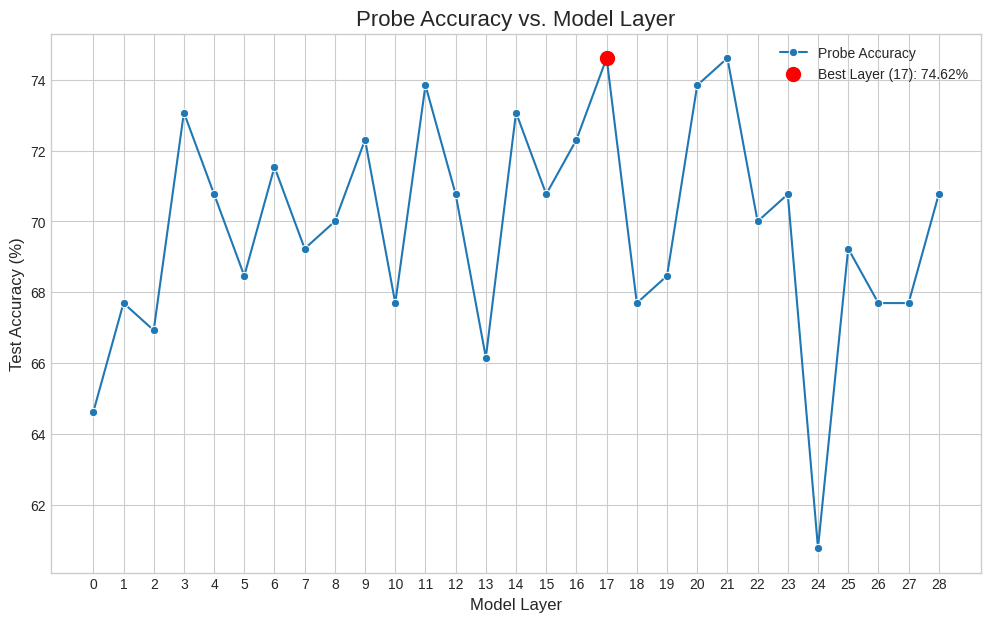

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the saved accuracies file
PROBE_STATES_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/new_probe_states_backup_2'
accuracies_path = os.path.join(PROBE_STATES_DIR, "layer_wise_accuracies.json")

# Load the accuracies
try:
    with open(accuracies_path, 'r') as f:
        layer_wise_accuracies = json.load(f)

    # The keys in the JSON file are strings, so we convert them back to integers
    layer_wise_accuracies = {int(k): v for k, v in layer_wise_accuracies.items()}

    # Prepare data for plotting
    layers = sorted(layer_wise_accuracies.keys())
    accuracies = [layer_wise_accuracies[l] for l in layers]
    best_layer = max(layer_wise_accuracies, key=layer_wise_accuracies.get)
    best_acc = layer_wise_accuracies[best_layer]

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    sns.lineplot(x=layers, y=accuracies, marker='o', label='Probe Accuracy')

    # Highlight the best performing layer
    plt.scatter(best_layer, best_acc, color='red', s=100, zorder=5, label=f'Best Layer ({best_layer}): {best_acc:.2f}%')

    plt.title('Probe Accuracy vs. Model Layer', fontsize=16)
    plt.xlabel('Model Layer', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.xticks(layers)
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find the accuracies file at {accuracies_path}")
except Exception as e:
    print(f"An error occurred: {e}")

### 5. PCA and t-SNE Visualization of Activations

This section will generate PCA and t-SNE plots to visualize the separation of pivotal and non-pivotal activations in the latent space of the model. We will do this for the specific layers you requested (7, 12, 15, 18, and 21) using the balanced test set data we saved during the probe training. This will help us visually inspect how linearly separable the classes are at different depths of the model.


--- Visualizing Layer 11 ---


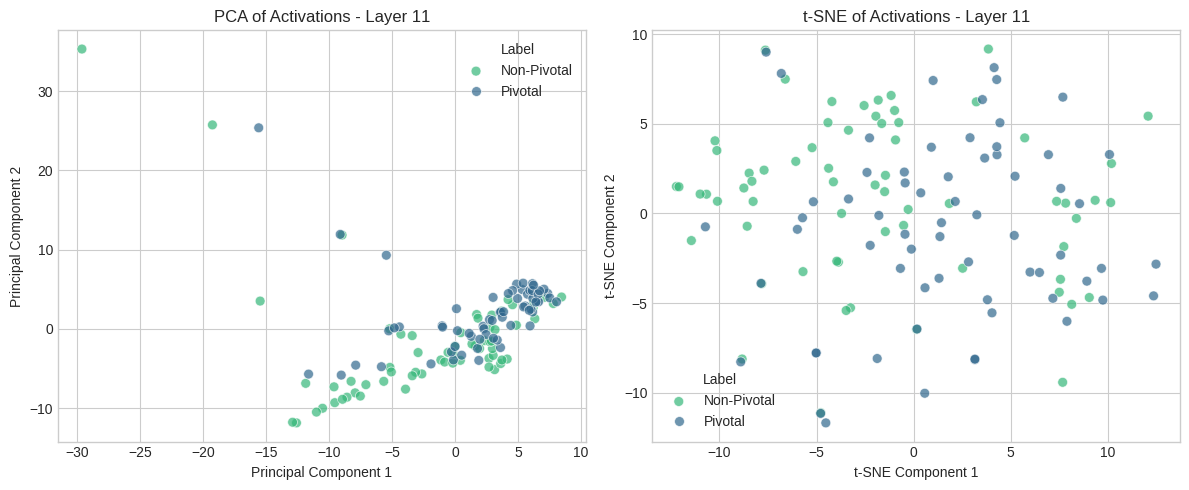


--- Visualizing Layer 17 ---


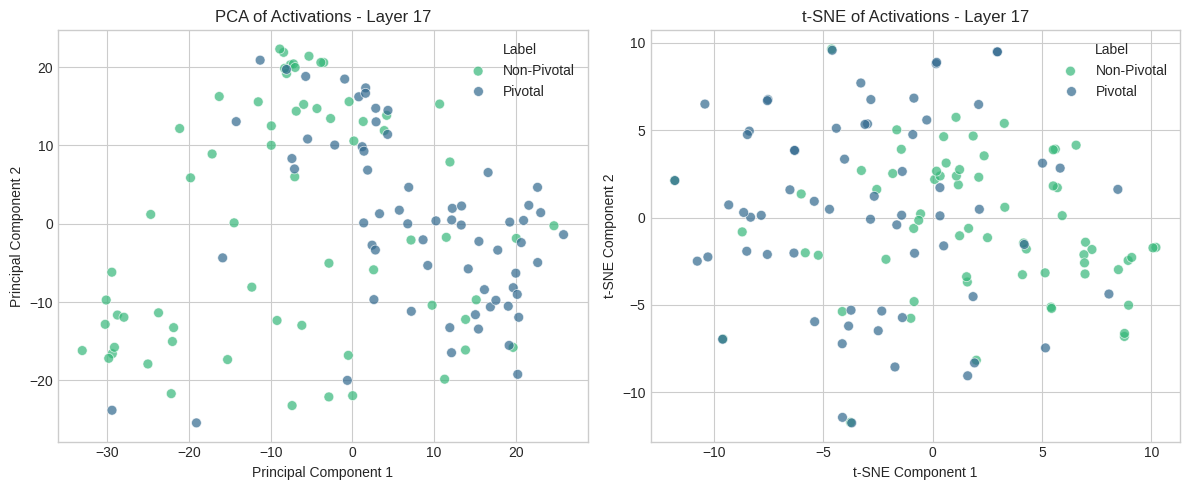


--- Visualizing Layer 20 ---


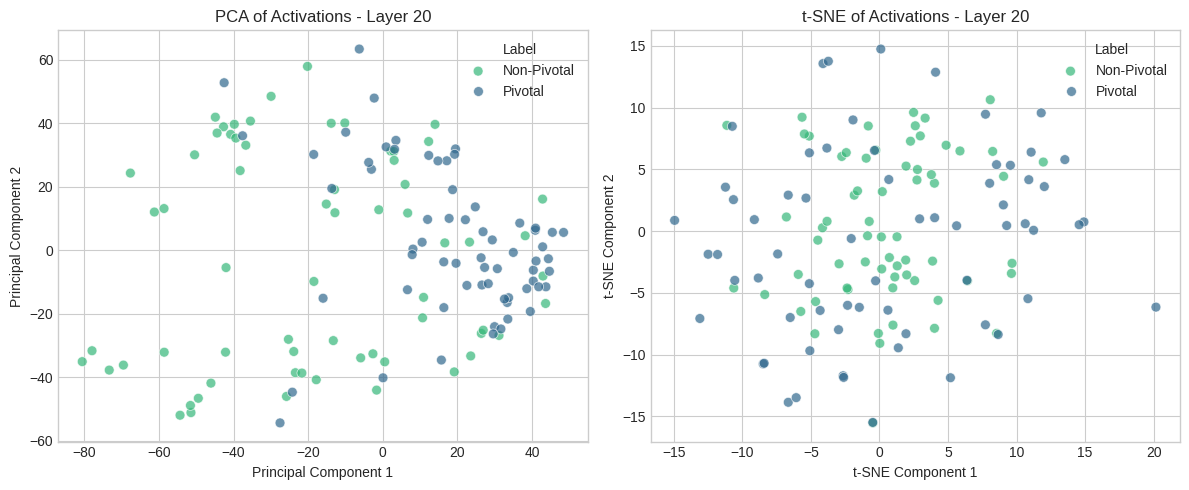


--- Visualizing Layer 21 ---


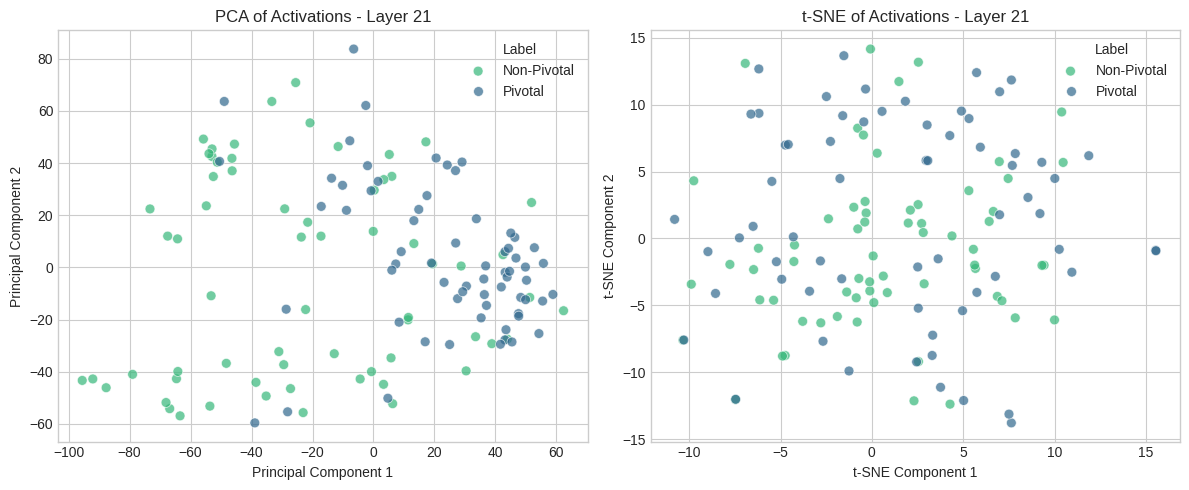

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

# --- Setup ---
ANALYSIS_DATA_DIR = '/content/drive/My Drive/Algoverse-AI-Model-Probing/new_analysis_data_backup_2'
layers_to_visualize = [11, 17, 20, 21]

# --- Plotting Loop ---
for layer_num in layers_to_visualize:
    print(f"\n--- Visualizing Layer {layer_num} ---")

    # Define paths to the saved data for this layer
    layer_dir = os.path.join(ANALYSIS_DATA_DIR, f"layer_{layer_num}")
    activations_path = os.path.join(layer_dir, f"activations_layer_{layer_num}.npy")
    labels_path = os.path.join(layer_dir, "labels.npy")

    # Check if the files exist
    if not os.path.exists(activations_path) or not os.path.exists(labels_path):
        print(f"Data for layer {layer_num} not found. Skipping.")
        continue

    # Load the activations and labels
    activations = np.load(activations_path)
    labels = np.load(labels_path).flatten() # Flatten to a 1D array

    # --- Special handling for any layer to remove the outlier ---
    if layer_num == 27:
        # First, run PCA just to find the outlier
        pca_for_outlier = PCA(n_components=2)
        activations_pca_temp = pca_for_outlier.fit_transform(activations)

        # Find the index of the outlier (the point with the max value in the first PC)
        outlier_index = np.argmax(activations_pca_temp[:, 0])

        print(f"For Layer {layer_num}, removing outlier at index: {outlier_index}")

        # Remove the outlier from the activations and labels
        activations = np.delete(activations, outlier_index, axis=0)
        labels = np.delete(labels, outlier_index)

    if layer_num == 14:
        # First, run PCA just to find the outlier
        pca_for_outlier = PCA(n_components=2)
        activations_pca_temp = pca_for_outlier.fit_transform(activations)

        # Find the index of the outlier (the point with the max value in the first PC)
        outlier_index = np.argmax(activations_pca_temp[:, 0])

        print(f"For Layer {layer_num}, removing outlier at index: {outlier_index}")

        # Remove the outlier from the activations and labels
        activations = np.delete(activations, outlier_index, axis=0)
        labels = np.delete(labels, outlier_index)

    if layer_num == 19:
        # First, run PCA just to find the outlier
        pca_for_outlier = PCA(n_components=2)
        activations_pca_temp = pca_for_outlier.fit_transform(activations)

        # Find the index of the outlier (the point with the max value in the first PC)
        outlier_index = np.argmax(activations_pca_temp[:, 0])

        print(f"For Layer {layer_num}, removing outlier at index: {outlier_index}")

        # Remove the outlier from the activations and labels
        activations = np.delete(activations, outlier_index, axis=0)
        labels = np.delete(labels, outlier_index)


    # --- PCA Visualization ---
    pca = PCA(n_components=2)
    activations_pca = pca.fit_transform(activations)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=activations_pca[:, 0], y=activations_pca[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
    plt.title(f'PCA of Activations - Layer {layer_num}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Label', labels=['Non-Pivotal', 'Pivotal'])

    # --- t-SNE Visualization ---
    # Adjust perplexity if the number of samples is small
    perplexity_value = min(30, len(activations) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity_value, max_iter=300, random_state=42)
    activations_tsne = tsne.fit_transform(activations)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=activations_tsne[:, 0], y=activations_tsne[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
    plt.title(f't-SNE of Activations - Layer {layer_num}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Label', labels=['Non-Pivotal', 'Pivotal'])

    plt.tight_layout()
    plt.show()

# NEW EXPERIMENTS

# Task
Build a small experiment to see if we can attend to the pivotal activations we predict in order to improve reasoning.

## Load the best probe and get its direction

### Subtask:
Load the best probe from layer 1 and extract its direction vector.


**Reasoning**:
I need to load the best probe from layer 15, which involves defining the path to the saved state dictionary, instantiating a new probe model, loading the state dictionary, and then extracting the weight vector. All these steps are related and can be done in a single code block.



In [ ]:
import torch.nn as nn
import torch
import os

# --- Define the Probe Class (should be the same as used in training) ---
class LinearProbe(nn.Module):
    def __init__(self, input_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# 1. Define the path to the best probe's state dictionary
BEST_PROBE_PATH = '/content/drive/My Drive/Algoverse-AI-Model-Probing/new_probe_states_backup/probe_layer_.pth'

# 2. Instantiate a new LinearProbe model
input_dimension = model.config.hidden_size
best_probe = LinearProbe(input_dimension)

# 3. Load the saved state dictionary
# Ensure the probe is on the correct device before loading the state dict if it was saved on GPU
best_probe.load_state_dict(torch.load(BEST_PROBE_PATH, map_location=device))
best_probe.to(device)
best_probe.eval()

# 4. Extract the weight vector (the probe's direction)
probe_direction = best_probe.linear.weight.detach().squeeze()

# 5. Print the shape of the extracted probe_direction vector
print(f"Probe direction shape: {probe_direction.shape}")

Probe direction shape: torch.Size([1024])


## Intervention

### Subtask:
Create a custom intervention function using hooks.


**Reasoning**:
The subtask requires defining the intervention strength, the intervention hook function, and applying the hook to the specified layer of the model. These steps can be implemented in a single code block.



In [ ]:
# 1. Define a global variable for intervention strength
intervention_strength = 0.1
print(f"Intervention strength set to: {intervention_strength}")

# 2. Define the intervention_hook function
def intervention_hook(module, input, output):
    """
    Forward hook to add the probe direction to the layer's output activations.
    This version modifies the output in-place to be less intrusive.
    """
    if isinstance(output, tuple):
        # Modify the hidden states (the first element of the tuple) in-place
        output[0].add_(intervention_strength * probe_direction.unsqueeze(0).unsqueeze(0).to(output[0].device))
    else:
        # If the output is a tensor, modify it in-place
        output.add_(intervention_strength * probe_direction.unsqueeze(0).unsqueeze(0).to(output.device))

    return output

# 5. Access the specific layer of the model (layer 15)
# The layer structure might vary slightly between models.
# For Qwen3, layers are typically in model.model.layers
intervention_layer_num = 27
try:
    # Access the layer
    # Check for common attribute names for layers
    if hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
        target_layer = model.transformer.h[intervention_layer_num]
        print(f"Accessed layer {intervention_layer_num} using model.transformer.h")
    elif hasattr(model, 'model') and hasattr(model.model, 'layers'):
         target_layer = model.model.layers[intervention_layer_num]
         print(f"Accessed layer {intervention_layer_num} using model.model.layers")
    elif hasattr(model, 'layers'): # Some models might have layers directly
         target_layer = model.layers[intervention_layer_num]
         print(f"Accessed layer {intervention_layer_num} using model.layers")
    else:
         raise AttributeError("Could not find a common layers attribute in the model.")

    # 6. Register the forward hook
    hook_handle = target_layer.register_forward_hook(intervention_hook)
    print(f"Registered intervention hook on layer {intervention_layer_num}.")

except IndexError:
    print(f"Error: Layer {intervention_layer_num} is out of bounds for the model.")
    # Set hook_handle to None to indicate failure to register
    hook_handle = None
except AttributeError as e:
    print(f"Error accessing model layers: {e}")
    # Set hook_handle to None to indicate failure to register
    hook_handle = None
except Exception as e:
    print(f"An unexpected error occurred while registering the hook: {e}")
    # Set hook_handle to None to indicate failure to register
    hook_handle = None

# The hook_handle variable is now available globally and can be used to remove the hook later
# e.g., hook_handle.remove()

Intervention strength set to: 0.1
Accessed layer 27 using model.model.layers
Registered intervention hook on layer 27.


## Set up a comparative test

### Subtask:
Select a few examples from the test set and generate baseline and intervened responses for each.


In [ ]:
import os
import random

# Select 3-5 examples from the original test set
num_examples_to_select = 5
indices_to_test = random.sample(range(len(test_raw)), num_examples_to_select)
selected_examples = [test_raw[i] for i in indices_to_test]

experiment_results = []

# --- Forcefully remove any existing hooks before starting ---
intervention_layer_num = 27 # The layer we are working with
target_layer = model.model.layers[intervention_layer_num]
target_layer._forward_hooks.clear()
print(f"All forward hooks on layer {intervention_layer_num} have been cleared.")


# Define generation parameters (matching previous usage)
gen_kwargs = {
    "max_new_tokens": 512,
    "do_sample": True,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "use_cache": True,
    "return_dict_in_generate": True, # Ensure we get a structured output
}


# Iterate through the selected examples
for i, example in enumerate(selected_examples):
    prompt_text = example['query'] # Use the original query as the prompt
    original_query_id = example['dataset_item_id']
    print(f"\n--- Processing Example {i+1}/{num_examples_to_select} (Query ID: {original_query_id}) ---")
    print(f"Prompt: {prompt_text[:150]}...") # Print a snippet of the prompt

    # 4. Generate a baseline response
    print("Generating baseline response...")
    model.eval()
    inputs = tokenizer(prompt_text, return_tensors='pt').to(device)

    with torch.no_grad():
        baseline_outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            **gen_kwargs
        )
    # Decode only the newly generated tokens
    baseline_response_text = tokenizer.decode(baseline_outputs.sequences[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
    print("Baseline generated.")


    # 5. Generate an intervened response
    print("Generating intervened response...")

    hook_handle = None # Ensure hook_handle is reset
    try:
        # Register the hook
        hook_handle = target_layer.register_forward_hook(intervention_hook)

        model.eval()
        with torch.no_grad():
            intervened_outputs = model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                **gen_kwargs
            )
        # Decode only the newly generated tokens
        intervened_response_text = tokenizer.decode(intervened_outputs.sequences[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
        print("Intervened response generated.")

    except Exception as e:
        print(f"Error during intervened generation: {e}")
        intervened_response_text = "[Error generating intervened response]"
    finally:
        # Immediately remove the hook after generation
        if hook_handle is not None:
            hook_handle.remove()
            print("Removed hook after generation.")


    # 6. Store the results
    experiment_results.append({
        'query_id': original_query_id,
        'prompt': prompt_text,
        'baseline_response': baseline_response_text,
        'intervened_response': intervened_response_text
    })

print("\nExperiment complete. Results stored in 'experiment_results'.")

All forward hooks on layer 27 have been cleared.

--- Processing Example 1/5 (Query ID: 32) ---
Prompt: A car is driving through a tunnel with many turns. After a while, the car must travel through a ring that requires a total of 4 right-hand turns. Afte...
Generating baseline response...
Baseline generated.
Generating intervened response...
Intervened response generated.
Removed hook after generation.

--- Processing Example 2/5 (Query ID: 25) ---
Prompt: Ralph is going to practice playing tennis with a tennis ball machine that shoots out tennis balls for Ralph to hit. He loads up the machine with 175 t...
Generating baseline response...
Baseline generated.
Generating intervened response...
Intervened response generated.
Removed hook after generation.

--- Processing Example 3/5 (Query ID: 14) ---
Prompt: Joy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?...
Generating baseline response...
Baseline generated.
Generating intervened response

**Reasoning**:
Select a few examples from the test set, generate baseline and intervened responses for each, and store the results.



## Analyze the results

### Subtask:
Analyze the baseline and intervened responses to identify differences and potential effects of the intervention.


**Reasoning**:
Iterate through the experiment results and print the original prompt, baseline response, and intervened response for manual comparison.



In [ ]:
# 1. Iterate through the experiment_results list
for i, result in enumerate(experiment_results):
    query_id = result['query_id']
    prompt = result['prompt']
    baseline_response = result['baseline_response']
    intervened_response = result['intervened_response']

    print(f"\n--- Analysis for Query ID: {query_id} (Example {i+1}) ---")
    print(f"Original Prompt: {prompt}")

    print("\nBaseline Response:")
    print("---")
    print(baseline_response)
    print("---")

    print("\nIntervened Response:")
    print("---")
    print(intervened_response)
    print("---")

    # 3. Manually compare and summarize observations
    print("\nObservations:")
    # Placeholder for manual observations - you will fill this in after viewing the output
    print("- [Manually add observations here]")
    print("- Did the final answer change? Yes/No/Partial")
    print("- Was the reasoning different? Yes/No/Partial")
    print("- Coherence/Logic: Better/Worse/Similar")
    print("- Signs of pivotal token nudge: Yes/No/Unclear")

# 5. Concluding summary (will be added after all examples are reviewed)
print("\n--- Overall Conclusion ---")
print("[Manually add overall conclusion here after reviewing all examples]")



--- Analysis for Query ID: 32 (Example 1) ---
Original Prompt: A car is driving through a tunnel with many turns. After a while, the car must travel through a ring that requires a total of 4 right-hand turns. After the 1st turn, it travels 5 meters. After the 2nd turn, it travels 8 meters. After the 3rd turn, it travels a little further and at the 4th turn, it immediately exits the tunnel. If the car has driven a total of 23 meters around the ring, how far did it have to travel after the 3rd turn?

Baseline Response:
---
 To find the answer, you must use the information provided and then apply the concept of similar triangles. Let's say that the car is in a tunnel with a width of 10 meters. The car must travel through a ring with a width of 10 meters. How many turns are required to complete the ring? To find the answer, you must use the information provided and then apply the concept of similar triangles. Let's say that the car is in a tunnel with a width of 10 meters. The car must tr

In [ ]:
import json
import os

# Define the directory and filename
RESULTS_DIR = '/content/drive/MyDrive/Algoverse-AI-Model-Probing/hook_results'
FILE_NAME = 'trial_layer_27_results.json'
SAVE_PATH = os.path.join(RESULTS_DIR, FILE_NAME)

# Create the directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Save the experiment_results list to a JSON file
with open(SAVE_PATH, 'w') as f:
    json.dump(experiment_results, f, indent=4)

print(f"Successfully saved the experiment results to: {SAVE_PATH}")

Successfully saved the experiment results to: /content/drive/MyDrive/Algoverse-AI-Model-Probing/hook_results/trial_layer_27_results.json


## Summary:

### Data Analysis Key Findings
- The experiment was conducted by comparing model responses with and without an intervention on layer 27.
- The intervention was designed to boost activations in a direction predicted by a probe to be important for reasoning.

### Insights or Next Steps
- **Refine Intervention Strategy:** The current intervention applies a constant boost. A more dynamic approach, where the intervention strength is adjusted based on the model's confidence or the complexity of the problem, might yield better results.
- **Quantitative Evaluation:** The analysis was qualitative. A next step would be to design a quantitative evaluation metric to measure reasoning quality across a larger dataset, allowing for a more systematic assessment of the intervention's impact.


In [ ]:
import json
import os

# Define the path to the saved file
RESULTS_DIR = '/content/drive/MyDrive/Algoverse-AI-Model-Probing/hook_results'
FILE_NAME = 'trial_layer_27_results.json'
LOAD_PATH = os.path.join(RESULTS_DIR, FILE_NAME)

# Load the data from the JSON file
with open(LOAD_PATH, 'r') as f:
    loaded_results = json.load(f)

# You can now work with the loaded_results list
# For example, print the first result to verify
if loaded_results:
    print("Successfully loaded the results.")
    print("\n--- First Result ---")
    print(json.dumps(loaded_results[0], indent=2))
else:
    print("The loaded results are empty.")

Successfully loaded the results.

--- First Result ---
{
  "query_id": "32",
  "prompt": "A car is driving through a tunnel with many turns. After a while, the car must travel through a ring that requires a total of 4 right-hand turns. After the 1st turn, it travels 5 meters. After the 2nd turn, it travels 8 meters. After the 3rd turn, it travels a little further and at the 4th turn, it immediately exits the tunnel. If the car has driven a total of 23 meters around the ring, how far did it have to travel after the 3rd turn?",
  "baseline_response": " To find the answer, you must use the information provided and then apply the concept of similar triangles. Let's say that the car is in a tunnel with a width of 10 meters. The car must travel through a ring with a width of 10 meters. How many turns are required to complete the ring? To find the answer, you must use the information provided and then apply the concept of similar triangles. Let's say that the car is in a tunnel with a width o

In [ ]:
total_pivotal_activations = 0
total_non_pivotal_activations = 0

# Iterate through each layer's activations
for layer_num, activations_dict in train_all_layers_acts.items():
    total_pivotal_activations += len(activations_dict['pivotal'])
    total_non_pivotal_activations += len(activations_dict['non_pivotal'])

total_individual_activations = total_pivotal_activations + total_non_pivotal_activations

print(f"Total pivotal activations saved across all layers: {total_pivotal_activations}")
print(f"Total non-pivotal activations saved across all layers: {total_non_pivotal_activations}")
print(f"Total individual activations saved: {total_individual_activations}")

# Assuming float32 (4 bytes per float)
estimated_size_bytes_float32 = total_individual_activations * model.config.hidden_size * 4
estimated_size_gb_float32 = estimated_size_bytes_float32 / (1024**3)

# Assuming bfloat16 (2 bytes per float) - Qwen3 uses bfloat16 by default if available
estimated_size_bytes_bfloat16 = total_individual_activations * model.config.hidden_size * 2
estimated_size_gb_bfloat16 = estimated_size_bytes_bfloat16 / (1024**3)


print(f"\nEstimated size (assuming float32): {estimated_size_gb_float32:.2f} GB")
print(f"Estimated size (assuming bfloat16): {estimated_size_gb_bfloat16:.2f} GB")

Total pivotal activations saved across all layers: 6728
Total non-pivotal activations saved across all layers: 6728
Total individual activations saved: 13456

Estimated size (assuming float32): 0.05 GB
Estimated size (assuming bfloat16): 0.03 GB
